# OOD detection applied to Hallucination Detection

 The goal is to predict if an INPUT prompt  is going to produce an hallucination or not (using OOD detection methods). For now, we don’t look at the output generated by the model, we may consider this in a second time. Retrieve ID samples:  To do this, take a general (easy) QA dataset containing questions along with their true hallucination-free answers. Feed the questions to the model. Let the model generate responses and check if the a given generated response is the same as the real hallucination-free answer. All the correct generated responses will be considered ID. More precisely, the ID dataset will consist of the embeddings of the last token of the last layer of the input (or maybe middle layer) of the correct generated responses.  Test a new sample to see if this is going to be OOD=hallucination: Take another dataset containing questions susceptible to trigger hallucinations along with the true hallucination-free answers (or no answer if the model cannot know the answer by any way and all response that the model might produce will necessarily be hallucinated). Feed a question to the model and let it generate a response. Check by comparing to the hallucination-free answer is that generated response is hallucinated or not. At the same time, apply an OOD detection method on the input question (at the last token last layer) and see if there is a correspondence between a high OOD score and a generated hallucination. 

In [1]:
# import libraries
# -----------------------------------
import torch
import sys
import time 
import os 
# Add the path to the src directory
sys.path.append(os.path.abspath(".."))

In [2]:
SEED = 44
BATCH_SIZE = 16
MODEL_NAME = "meta-llama/Llama-2-7b-chat-hf"
OUTPUT_DIR = "../results/raw/"

In [3]:
# Visualize setup 
# -----------------------------------
print(f"Python version: {sys.version}")
print(f"Cuda version: {torch.version.cuda}")
num_gpus = torch.cuda.device_count()
print(f"Number of available de GPU : {num_gpus}")
for i in range(num_gpus):
    print(f"GPU {i + 1} : {torch.cuda.get_device_name(i)}")

Python version: 3.11.13 (main, Jun  4 2025, 08:57:30) [GCC 13.3.0]
Cuda version: 12.6
Number of available de GPU : 2
GPU 1 : NVIDIA L40S
GPU 2 : NVIDIA L40S


In [4]:
# Seed everything
# -----------------------------------
from src.utils.general import seed_all
seed_all(SEED)

## Load model

In [5]:
# Load model
# -----------------------------------
from src.model_loader.llama_loader import load_llama

model, tokenizer = load_llama(MODEL_NAME)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Load ID dataset

For the ID general dataset, we are going to use the SQUAD 1.1 dataset: 

***SQuAD 1.1:** Comprises over 100,000 question-answer pairs derived from more than 500 Wikipedia articles. Each question is paired with a specific segment of text (a span) from the corresponding article that serves as the answer.*

In [8]:
# Load ID dataset
# -----------------------------------
from src.data_reader.squad_loader import load_id_fit_dataset

id_fit_dataset = load_id_fit_dataset()
id_fit_dataset = id_fit_dataset.shuffle(SEED) 
id_fit_dataset = id_fit_dataset.slice(idx_start=0, idx_end=10000)
id_fit_dataset.print_info()


===== Dataset Information =====
Dataset({
    features: ['id', 'title', 'context', 'question', 'answers', 'original_index', 'is_impossible'],
    num_rows: 10000
})
Mean ground-truth answer length: 3.19, Max length: 30
Mean context + question length: 129.68, Max length: 497


In [7]:
# Visualize one generation with the ID dataset
# -----------------------------------
from src.inference.inference_utils import analyze_single_generation, build_prompt, get_layer_output, extract_last_token_activations

_ = analyze_single_generation(
    model=model,
    tokenizer=tokenizer, 
    dataset=id_fit_dataset,
    sample_idx=0,
    build_prompt_fn=build_prompt,
    get_layer_output_fn=get_layer_output,
    layer_idx=-1,
    extract_token_activations_fn=extract_last_token_activations,
    offset=-5
)

========= Analyze one generation  =========
----- Prompt construction: 0.000 sec
----- Tokenization: 0.003 sec
----- Token extraction: 0.390 sec
----- Generation: 0.606 sec
----- Decoding: 0.000 sec
----- Similarity scoring: 0.043 sec

=== Prompt ===
<s>[INST]

Just give the answer, without a complete sentence.           

Context:
Under a front page headline "The Truth", the paper printed allegations provided to them that some fans picked the pockets of crushed victims, that others urinated on members of the emergency services as they tried to help and that some even assaulted a police constable "whilst he was administering the kiss of life to a patient." Despite the headline, written by Kelvin MacKenzie, the story was based on allegations either by unnamed and unattributable sources, or hearsay accounts of what named individuals had said – a fact made clear to MacKenzie by Harry Arnold, the reporter who wrote the story.

Question:
What was the story based on?

Answer:
[/INST]

=== Sh

## Retrieve ID embeddings

In [ ]:
# Retrieve ID embeddings and save results 
# -----------------------------------
from src.inference.inference_utils import batch_extract_token_activations_with_generation, build_prompt, get_layer_output, extract_last_token_activations
from src.utils.general import print_time_elapsed

# Runs batched inference on a dataset using a decoder-only language model.
# For each batch, generates answers, computes semantic similarity scores, extracts token-level activations,
# and appends the results to a pickle file.
print("\nStart retrieving ID embeddings...")
t0 = time.time()

batch_extract_token_activations_with_generation(
    model=model,
    tokenizer=tokenizer,
    dataset=id_fit_dataset,
    batch_size=BATCH_SIZE,
    idx_start_sample=0,
    max_samples=len(id_fit_dataset),
    output_path = OUTPUT_DIR + "id_fit_results.pkl",
    build_prompt_fn=build_prompt,
    get_layer_output_fn=get_layer_output,
    layer_idx=-1,  
    extract_token_activations_fn=extract_last_token_activations,
    offset=-5
)

t1 = time.time()
print("...end!")
print_time_elapsed(t0, t1, label="ID embeddings: ")

: 

In [9]:
# Free memory 
del id_fit_dataset

## Load OOD/Hallucinations test datasets 

To evaluate the Hallucination detection in question answering using OOD detection methods, we will use datasets in the SQuAD style:

***SQuAD 2.0:** SQuAD 2.0 extends the original **SQuAD 1.1** dataset by adding around 50,000 unanswerable questions. These questions are carefully designed to look similar to answerable ones, making it more challenging for models to determine when there isn’t enough information in the context to provide an answer.*

**Test Dataset Composition** \
Our test set will include two types of samples:
- ***Impossible samples***: Questions that cannot be answered based on the provided context (i.e., the answer is not present in the text). These are taken from the training split of SQuAD 2.0, selecting only the unanswerable questions.
- ***Possible samples***: Questions where the answer is explicitly present in the context. These are drawn from the validation split of SQuAD 1.1. This ensures there is no overlap with the in-distribution (ID) data from the SQuAD 1.1 training split.

**Note on Evaluation Scope**\
Currently, our evaluation focuses on whether the model can answer questions using only the information provided in the input context. We do not test the model’s internal knowledge or ability to answer questions without supporting context. However, this setup closely matches the OOD scenario: if the information is not in the text, the model should recognize and indicate this.

**Additional Dataset: TriviaQA**\
To further test generalization, we will also use the TriviaQA dataset. Like SQuAD, TriviaQA provides question-answering prompts with supporting context. The model must either extract the correct answer from the context or correctly identify when the answer is not present.


In [ ]:
# Load test datasets
# -----------------------------------
from src.data_reader.squad_loader import load_id_test_dataset, load_od_test_dataset

# Load possible test dataset 
id_test_dataset = load_id_test_dataset()
id_test_dataset = id_test_dataset.shuffle(SEED) 
id_test_dataset = id_test_dataset.slice(idx_start=0, idx_end=1000)
id_test_dataset.print_info()

# Load impossible test dataset 
od_test_dataset = load_od_test_dataset()
od_test_dataset = od_test_dataset.shuffle(SEED) 
od_test_dataset = od_test_dataset.slice(idx_start=0, idx_end=1000)
od_test_dataset.print_info()


In [11]:
# Visualize one generation with the test impossible dataset
# -----------------------------------
from src.inference.inference_utils import analyze_single_generation, build_impossible_prompt, get_layer_output, extract_last_token_activations

_ = analyze_single_generation(
    model=model,
    tokenizer=tokenizer, 
    dataset=od_test_dataset,
    sample_idx=3,
    build_prompt_fn=build_impossible_prompt,
    get_layer_output_fn=get_layer_output,
    layer_idx=-1,
    extract_token_activations_fn=extract_last_token_activations,
    offset=-5
)

========= Analyze one generation  =========
----- Prompt construction: 0.000 sec
----- Tokenization: 0.021 sec
----- Token extraction: 0.044 sec
----- Generation: 0.076 sec
----- Decoding: 0.000 sec
----- Similarity scoring: 0.004 sec

=== Prompt ===
<s>[INST]

Just give the answer, without a complete sentence. Reply with 'Impossible to answer' if answer not in context.            

Context:
In the Catholic Church, canon law is the system of laws and legal principles made and enforced by the Church's hierarchical authorities to regulate its external organization and government and to order and direct the activities of Catholics toward the mission of the Church.

Question:
What mission this Canon law directly activities of all Christians towards?

Answer:
[/INST]

=== Shapes ===
Shape - number of tokens: torch.Size([1, 119])
Shape - selected_layer: torch.Size([1, 119, 4096])

=== Generated Answer ===
Mission

=== Ground-truth Answer ===


=== Similarity Scores ===
ROUGE-L F1: 0.0000
Sen

## Retrieve test embeddings 

Test embeddings which may be OOD/Hallucinations.

In [16]:
# Retrieve test embeddings and save results 
# -----------------------------------
from src.inference.inference_utils import batch_extract_token_activations, build_prompt, get_layer_output, extract_last_token_activations
from src.utils.general import print_time_elapsed

# Runs batched inference on a dataset using a decoder-only language model.
# For each batch, gextracts token-level activations, and appends the results to a pickle file.
print("\nStart retrieving test impossible embeddings...")
t2 = time.time()
batch_extract_token_activations(
    model=model,
    tokenizer=tokenizer,
    dataset=od_test_dataset,
    batch_size=BATCH_SIZE,
    idx_start_sample=0,
    max_samples=len(od_test_dataset),
    save_to_pkl = True,
    output_path = OUTPUT_DIR + "od_test_results.pkl",
    build_prompt_fn=build_prompt,
    get_layer_output_fn=get_layer_output,
    layer_idx=-1,  
    extract_token_activations_fn=extract_last_token_activations,
    offset=-5
)
t3 = time.time()
print("...end!")
print_time_elapsed(t2, t3, label="Test impossible embeddings: ")


print("\nStart retrieving test possible embeddings...")
t4 = time.time()
batch_extract_token_activations(
    model=model,
    tokenizer=tokenizer,
    dataset=id_test_dataset,
    batch_size=BATCH_SIZE,
    idx_start_sample=0,
    max_samples=len(id_test_dataset),
    save_to_pkl = True,
    output_path = OUTPUT_DIR + "id_test_results.pkl",
    build_prompt_fn=build_prompt,
    get_layer_output_fn=get_layer_output,
    layer_idx=-1,  
    extract_token_activations_fn=extract_last_token_activations,
    offset=-5
)
t5 = time.time()
print("...end!")
print_time_elapsed(t4, t5, label="Test possible embeddings: ")


Start retrieving test impossible embeddings...


100%|██████████| 63/63 [00:50<00:00,  1.24it/s]


...end!
Test impossible embeddings: Time elapsed: 00 min 50 sec


Start retrieving test possible embeddings...


100%|██████████| 63/63 [00:51<00:00,  1.22it/s]

...end!
Test possible embeddings: Time elapsed: 00 min 51 sec



In [17]:
# Free memory 
del od_test_dataset 
del id_test_dataset

## Load extracted embeddings 

In [18]:
# Load ID embeddings 
# -----------------------------------
from src.data_reader.pickle_io import load_pickle_batches
from src.utils.general import filter_correct_entries

# Load extracted embeddings 
id_fit_embeddings = load_pickle_batches(OUTPUT_DIR + "id_fit_results.pkl")
# Only keep rows with simiar generated and ground-truth answers
id_fit_embeddings = filter_correct_entries(id_fit_embeddings) 
# Concatenate all embeddings 
id_fit_embeddings = torch.cat(id_fit_embeddings['activations'], dim=0) # shape: [N, D]


Loaded 10000 samples from: ../results/raw/id_fit_results.pkl
Size before filtering incorrect samples: 10000.
Size after filtering: 8865. Filtered 1135 samples.


In [19]:
# Load test embeddings 
# -----------------------------------
from src.data_reader.pickle_io import load_pickle_batches

# Load extracted possible and impossible embeddings 
od_test_embeddings = load_pickle_batches(OUTPUT_DIR + "id_test_results.pkl")
id_test_embeddings = load_pickle_batches(OUTPUT_DIR + "od_test_results.pkl")
# Concatenate possible and impossible all embeddings 
od_test_embeddings = torch.cat(od_test_embeddings['activations'], dim=0) # shape: [N, D]
id_test_embeddings = torch.cat(id_test_embeddings['activations'], dim=0) # shape: [N, D]

Loaded 1000 samples from: ../results/raw/id_test_results.pkl
Loaded 1000 samples from: ../results/raw/od_test_results.pkl


## Perform DKNN

In [22]:
# Constructs the FAISS index from ID data.
# -----------------------------------
from src.analysis.dknn import fit_to_dataset
index = fit_to_dataset(id_fit_embeddings, use_gpu=True)

In [23]:
# Compute DKNN scores on test data
# -----------------------------------
from src.analysis.dknn import score_tensor
k=50
dknn_scores_id  = score_tensor(index, id_test_embeddings, nearest=k, batch_size=BATCH_SIZE)
dknn_scores_ood = score_tensor(index, od_test_embeddings, nearest=k, batch_size=BATCH_SIZE)

auROC: 0.5229


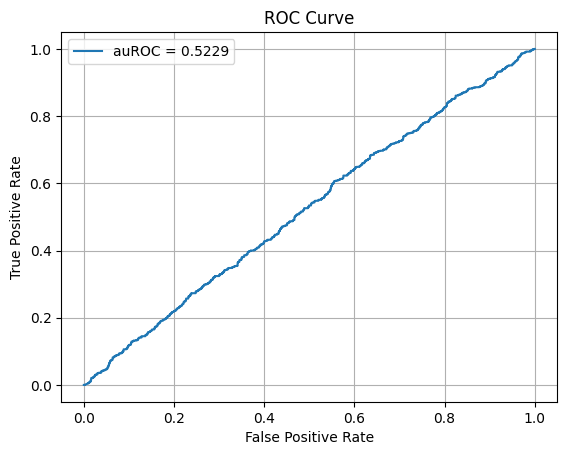

AUROC: 0.5229


In [24]:
# Compute and plot auroc 
# -----------------------------------
from src.analysis.dknn import compute_auroc
auroc, fpr, tpr, thresholds = compute_auroc(dknn_scores_id, dknn_scores_ood, plot=True)
print(f"AUROC: {auroc:.4f}")

:'(

# Brouillon

In [10]:
from src.inference.inference_utils import build_prompt, get_layer_output, compute_token_offsets

In [91]:
def extract_average_token_activations(
    selected_layer: torch.Tensor,
    attention_mask: torch.Tensor,
    device: torch.device,
    start_offset : int = 0,
    end_offset : int = 0
) -> torch.Tensor:
    """
    Extract the mean activation vector over a token span for each sequence in a batch.
    The span is defined by applying start_offset (from the first non-padding token)
    and end_offset (from the last non-padding token).

    Parameters
    ----------
    selected_layer : torch.Tensor
        Output tensor from the selected model layer (batch_size x seq_len x hidden_size).
    attention_mask : torch.Tensor
        Attention mask (batch_size x seq_len).
    device : torch.device
        Device for computation.
    start_offset : int
        Offset from first non-padding token (to skip e.g. [INST]).
    end_offset : int
        Offset from last non-padding token (to skip e.g. [/INST]).

    Returns
    -------
    torch.Tensor
        Averaged embeddings (batch_size x hidden_size)
    """
    batch_size, seq_len, _ = selected_layer.shape

    # Detect left padding if any sequence starts with padding
    is_left_padding = (attention_mask[:, 0] == 0).any()

    # Find the index of the first and the  last non-padding token for each sequence
    if is_left_padding:
        #--- For left padding, first non-padding token is at index: number of padding tokens
        first_indices = attention_mask.argmax(dim=1)
        #--- For left padding, last non-padding token is at the end: compute its index by flipping and offsetting from the end
        last_indices = (attention_mask.size(1) - 1) - attention_mask.flip(dims=[1]).argmax(dim=1)
    else:
        #--- For right padding, first non-padding token is always at index 0
        first_indices = torch.zeros(batch_size, dtype=torch.long, device=device)
        #--- For right padding, last non-padding token is at: (number of non-padding tokens) - 1
        last_indices = (attention_mask.sum(dim=1) - 1)

    first_indices = first_indices.to(device)
    last_indices = last_indices.to(device)

    # Apply offsets (e.g., skip <s> [INST] or [\INST])
    target_first_indices = first_indices + start_offset #-1
    target_last_indices = last_indices + end_offset #+1

    # Clamp indices to valid range
    target_first_indices = torch.clamp(target_first_indices, min=0, max=seq_len - 1)
    target_last_indices = torch.clamp(target_last_indices, min=0, max=seq_len - 1)

    # Compute mask for averaging
    #--- Create a tensor of positions: shape (1, seq_len), then expand to (batch_size, seq_len)
    positions = torch.arange(seq_len, device=device).unsqueeze(0).expand(batch_size, seq_len)
    #--- Build a boolean mask: True where the position is within [target_first_indices, target_last_indices] for each sequence
    mask = (positions >= target_first_indices.unsqueeze(1)) & (positions <= target_last_indices.unsqueeze(1))
    #--- Convert the boolean mask to float and add a singleton dimension for broadcasting with selected_layer
    mask = mask.float().unsqueeze(-1)  # (batch_size, seq_len, 1)

    # Apply mask and compute mean
    #--- Apply the mask to the activations: zero out tokens outside the target interval
    masked = selected_layer * mask
    #--- Count the number of selected tokens for each sequence (avoid division by zero with clamp)
    counts = mask.sum(dim=1).clamp(min=1e-6)
    #--- Compute the mean activation vector for each sequence over the selected interval
    avg = masked.sum(dim=1) / counts # (batch_size, hidden_size)

    # Optionally, return also the indices used
    indices = torch.stack([target_first_indices, target_last_indices], dim=1)

    return avg, indices

In [11]:
from transformers import PreTrainedTokenizer, PreTrainedModel, BatchEncoding
import torch
from datasets import  Dataset
from tqdm import tqdm
from typing import Dict, List, Any, Callable
import time

from src.evaluation.similarity_metrics import rouge_l_simScore, sentence_bert_simScore
from src.inference.inference_utils import extract_batch, generate_answers

def batch_extract_token_activations_with_generation(
    model: PreTrainedModel,
    tokenizer: PreTrainedTokenizer,
    dataset: Dataset,
    batch_size: int = 2,
    idx_start_sample: int = 0,
    max_samples: int = 2,
    output_path: str = "outputs/all_batch_results.pkl",
    build_prompt_fn: Callable[[str, str], str] = None,
    get_layer_output_fn: Callable = None,
    layer_idx: int = -1,  
    extract_token_activations_fn: Callable = None,
    **kwargs
):
    """
    Runs batched inference on a dataset using a decoder-only language model.
    For each batch, generates answers, computes semantic similarity scores, extracts token-level activations,
    and appends the results to a pickle file.

    Parameters
    ----------
    model : PreTrainedModel
        The causal language model to evaluate (e.g., LLaMA).
    tokenizer : PreTrainedTokenizer
        The corresponding tokenizer.
    dataset : Dataset
        The input dataset.
    batch_size : int
        Number of samples per batch.
    idx_start_sample : int
        Index of the first sample to process from the dataset.
    max_samples : int
        Total number of examples to process from the dataset, starting from idx_start_sample. 
    output_path : str
        Path to the pickle file for saving intermediate results.
    build_prompt_fn : Callable
        Function to build a prompt from context and question.
    get_layer_output_fn : Callable
        Function to extract the output of a specific model layer.
    layer_idx : int
        Index of the transformer layer to extract activations from (default: -1 for last layer).
    extract_token_activations_fn : Callable
        Function to extract token activations from a model layer.
    **kwargs :
        Extra keyword arguments passed to extract_token_activations_fn.
    """
    for i in tqdm(range(idx_start_sample, idx_start_sample + max_samples, batch_size)):
        batch_answers = []               # Generated answers
        batch_gt_answers = []            # Ground-truth answers
        batch_is_correct = []            # 0/1 labels indicating correctness
        batch_dataset_ids = []           # 'id' field from dataset
        batch_dataset_original_idx = []  # Original indices from dataset
        batch_rouge_scores = []          # Rouge-L scores
        batch_sbert_scores = []          # Sentence-Bert scores

        batch = extract_batch(dataset, i, batch_size)
        prompts = [build_prompt_fn(s["context"], s["question"]) for s in batch]
        print(f"prompts: {prompts[0]},\n{prompts[1]}")
        answers = [s["answers"]["text"] for s in batch]
        inputs = tokenizer(prompts, padding=True, truncation=True, return_tensors="pt").to(model.device)
        print(f"inputs:", inputs)
        selected_layer = get_layer_output_fn(model, inputs, layer_idx)
        selected_token_vecs, target_indices = extract_token_activations_fn(
                selected_layer, 
                inputs["attention_mask"], 
                device=selected_layer.device,
                **kwargs) 
        print("selected_token_vecs", selected_token_vecs)
        
        for k in range(len(prompts)):
            print("=========DECODING==========")
            print("target_indices[k]", target_indices[k])
            print(f"\nDecoding START target_indices[k]:-----{tokenizer.decode(inputs['input_ids'][k][target_indices[k][0]:target_indices[k][1]+1])}-----Decoding end\n")
            print(f"SELECTED TOKENS ---{tokenizer.decode(inputs['input_ids'][k][target_indices[k][0]])} and {tokenizer.decode(inputs['input_ids'][k][target_indices[k][1]])}---")
        
        output_ids = generate_answers(model, inputs, tokenizer)
        
        for j in range(len(prompts)):
            # --- Decode token IDs into text ---
            prompt_len = len(inputs["input_ids"][j]) # Length of prompt j
            generated_answer_ids = output_ids[j][prompt_len:] # Remove prompt prefix to isolate the generated answer
            generated_answer = tokenizer.decode(generated_answer_ids, skip_special_tokens=True).strip()

            # --- Compute semantic similarity between model's answer and ground-truth ---    
            rouge_l_score = rouge_l_simScore(generated_answer, answers[j])
            if rouge_l_score >= 0.5:
                is_correct = True
                sbert_score = None
            else:
                sbert_score = sentence_bert_simScore(generated_answer, answers[j])
                is_correct = (sbert_score >= 0.4)

            # --- Store everything ---
            batch_dataset_ids.append(batch[j]['id'])
            batch_dataset_original_idx.append(batch[j]['original_index'])
            batch_answers.append(generated_answer)
            batch_gt_answers.append(answers[j])
            batch_is_correct.append(int(is_correct))
            batch_rouge_scores.append(rouge_l_score)
            batch_sbert_scores.append(sbert_score)

        # --- Save progress to pickle after each batch ---
        batch_results = {
            "id": batch_dataset_ids,
            "original_indices": batch_dataset_original_idx,
            "gen_answers": batch_answers,
            "ground_truths": batch_gt_answers,
            "activations": [selected_token_vecs[i].unsqueeze(0).cpu() for i in range(selected_token_vecs.size(0))],
            "is_correct": batch_is_correct,
            "sbert_scores": batch_sbert_scores,
            "rouge_scores": batch_rouge_scores
        }
        

In [11]:
text = build_prompt(id_fit_dataset[0]["context"], id_fit_dataset[0]["question"])
start_offset, end_offset = compute_token_offsets(
    text=text,
    tokenizer=tokenizer,
    start_phrase="<<SYS>>",
    end_phrase="Answer:\n",
    debug=True)

===== Input text =====
[INST] <<SYS>>
Just give the answer, without a complete sentence. Reply with 'Impossible to answer' if answer not in context.
<<SYS>>

Context:
Under a front page headline "The Truth", the paper printed allegations provided to them that some fans picked the pockets of crushed victims, that others urinated on members of the emergency services as they tried to help and that some even assaulted a police constable "whilst he was administering the kiss of life to a patient." Despite the headline, written by Kelvin MacKenzie, the story was based on allegations either by unnamed and unattributable sources, or hearsay accounts of what named individuals had said – a fact made clear to MacKenzie by Harry Arnold, the reporter who wrote the story.

Question:
What was the story based on?

Answer:
[/INST]

===== Decoded text between `start_offset` and `end_offset` =====
----START TEXT---<<SYS>>
Just give the answer, without a complete sentence. Reply with 'Impossible to answer

In [196]:
batch_extract_token_activations_with_generation(
    model=model,
    tokenizer=tokenizer,
    dataset=id_fit_dataset,
    batch_size=2,
    idx_start_sample= 0,
    max_samples= 2,
    output_path = "outputs/all_batch_results.pkl",
    build_prompt_fn=build_impossible_prompt,
    get_layer_output_fn=get_layer_output,
    layer_idx = -1,  
    extract_token_activations_fn=extract_average_token_activations,
    start_offset = start_offset,
    end_offset = end_offset
)

  0%|          | 0/1 [00:00<?, ?it/s]

prompts: [INST] <<SYS>>
Just give the answer, without a complete sentence. Reply with 'Impossible to answer' if answer not in context.
<<SYS>>

Context:
Under a front page headline "The Truth", the paper printed allegations provided to them that some fans picked the pockets of crushed victims, that others urinated on members of the emergency services as they tried to help and that some even assaulted a police constable "whilst he was administering the kiss of life to a patient." Despite the headline, written by Kelvin MacKenzie, the story was based on allegations either by unnamed and unattributable sources, or hearsay accounts of what named individuals had said – a fact made clear to MacKenzie by Harry Arnold, the reporter who wrote the story.

Question:
What was the story based on?

Answer:
[/INST],
[INST] <<SYS>>
Just give the answer, without a complete sentence. Reply with 'Impossible to answer' if answer not in context.
<<SYS>>

Context:
The term Carnival is traditionally used in 

100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


In [13]:
from src.inference.inference_utils import (
    build_prompt, 
    compute_token_offsets, 
    get_layer_output
)
text = build_prompt(id_fit_dataset[0]["context"], id_fit_dataset[0]["question"])
start_offset, end_offset = compute_token_offsets(
    text=text,
    tokenizer=tokenizer,
    start_phrase="\nContext:",
    end_phrase="Answer:\n",
    debug=True)


===== Input text =====
[INST] <<SYS>>
Just give the answer, without a complete sentence. Reply with 'Impossible to answer' if answer not in context.
<<SYS>>

Context:
Under a front page headline "The Truth", the paper printed allegations provided to them that some fans picked the pockets of crushed victims, that others urinated on members of the emergency services as they tried to help and that some even assaulted a police constable "whilst he was administering the kiss of life to a patient." Despite the headline, written by Kelvin MacKenzie, the story was based on allegations either by unnamed and unattributable sources, or hearsay accounts of what named individuals had said – a fact made clear to MacKenzie by Harry Arnold, the reporter who wrote the story.

Question:
What was the story based on?

Answer:
[/INST]

===== Decoded text between `start_offset` and `end_offset` =====
----START TEXT---
Context:
Under a front page headline "The Truth", the paper printed allegations provided t

In [23]:
batch_extract_token_activations_with_generation(
    model=model,
    tokenizer=tokenizer,
    dataset=id_fit_dataset,
    batch_size=2,
    idx_start_sample= 0,
    max_samples= 2,
    output_path = "outputs/all_batch_results.pkl",
    build_prompt_fn=build_impossible_prompt,
    get_layer_output_fn=get_layer_output,
    layer_idx = -1,  
    extract_token_activations_fn=extract_average_token_activations,
    start_offset = start_offset,
    end_offset = end_offset
)

  0%|          | 0/1 [00:00<?, ?it/s]

prompts: [INST] <<SYS>>
Just give the answer, without a complete sentence. Reply with 'Impossible to answer' if answer not in context.
<<SYS>>

Context:
Under a front page headline "The Truth", the paper printed allegations provided to them that some fans picked the pockets of crushed victims, that others urinated on members of the emergency services as they tried to help and that some even assaulted a police constable "whilst he was administering the kiss of life to a patient." Despite the headline, written by Kelvin MacKenzie, the story was based on allegations either by unnamed and unattributable sources, or hearsay accounts of what named individuals had said – a fact made clear to MacKenzie by Harry Arnold, the reporter who wrote the story.

Question:
What was the story based on?

Answer:
[/INST],
[INST] <<SYS>>
Just give the answer, without a complete sentence. Reply with 'Impossible to answer' if answer not in context.
<<SYS>>

Context:
The term Carnival is traditionally used in 

100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


In [45]:
from transformers import PreTrainedTokenizer, PreTrainedModel, BatchEncoding
import torch
from datasets import  Dataset
from tqdm import tqdm
from typing import Dict, List, Any, Callable, Tuple
import time
from src.inference.inference_utils import generate_answers, extract_batch

def batch_extract_answer_token_activations(
    model: PreTrainedModel,
    tokenizer: PreTrainedTokenizer,
    dataset: Dataset,
    batch_size: int = 4,
    idx_start_sample: int = 0,
    max_samples: int = 1000,
    output_path: str = "outputs/all_batch_results.pkl",
    build_prompt_fn: Callable[[str, str], str] = None,
    get_layer_output_fn: Callable = None,
    layer_idx: int = -1,  
    extract_token_activations_fn: Callable = None, 
    include_prompt: bool = True,
    **kwargs
):
    """
    Runs batched inference on a dataset using a decoder-only language model.
    For each batch, generates answers, extracts token-level activations for the generated answer,
    and appends the results to a pickle file.

    Parameters
    ----------
    model : PreTrainedModel
        The causal language model to evaluate (e.g., LLaMA).
    tokenizer : PreTrainedTokenizer
        The corresponding tokenizer.
    dataset : Dataset
        The input dataset.
    batch_size : int
        Number of samples per batch.
    idx_start_sample : int
        Index of the first sample to process from the dataset.
    max_samples : int
        Total number of examples to process from the dataset, starting from idx_start_sample. 
    output_path : str
        Path to the pickle file for saving intermediate results.
    build_prompt_fn : Callable
        Function to build a prompt from context and question.
    get_layer_output_fn : Callable
        Function to extract the output of a specific model layer. 
    layer_idx : int
        Index of the transformer layer to extract activations from (default: -1 for last layer).
    extract_token_activations_fn : Callable
        Function to extract token activations from a model layer (default is average).
    include_prompt : bool
        Whether to include the prompt in the embedding extraction.
        *Note:* Tokenization will always include the prompt.  
    **kwargs :
        Extra keyword arguments passed to extract_token_activations_fn, including start_offset.
    """
    for i in tqdm(range(idx_start_sample, idx_start_sample + max_samples, batch_size)):
        batch_answers = []               # Generated answers
        batch_generated_embeddings = []  # Embeddings of generated answers
        batch_dataset_ids = []           # 'id' field from dataset
        batch_dataset_original_idx = []  # Original indices from dataset

        # Extract a batch from the dataset
        batch = extract_batch(dataset, i, batch_size)
        prompts = [build_prompt_fn(s["context"], s["question"]) for s in batch]
        
        # Tokenize the prompt 
        inputs = tokenizer(prompts, padding=True, truncation=True, return_tensors="pt").to(model.device)

        # Generate the answers for the batch
        output_ids = generate_answers(model, inputs, tokenizer)
        
        for j in range(len(prompts)):
            print(f"***************** j={j} *****************")
            # --- Decode token IDs into text ---
            prompt_len = len(inputs["input_ids"][j])  # Length of the prompt for example j
            generated_answer_ids = output_ids[j][prompt_len:]  # Remove prompt part
            generated_answer = tokenizer.decode(generated_answer_ids, skip_special_tokens=True).strip()
            print("prompt_len: ", prompt_len)
            
            # Create the full sequence: prompt + generated answer
            full_input_sequence = tokenizer.decode(inputs["input_ids"][j], skip_special_tokens=True) + generated_answer
            print("full_input_sequence", full_input_sequence)
            
            # --- Tokenize the full sequence (prompt + generated answer) for activation extraction ---
            # We cannot directly use `output_ids` and need to retokenize since we need attention_mask for get_layer_output_fn
            full_inputs = tokenizer(full_input_sequence, padding=True, truncation=True, return_tensors="pt").to(model.device)
            print("full_inputs", full_inputs)

            # --- Extract token embeddings for the full sequence ---
            selected_layer = get_layer_output_fn(model, full_inputs, layer_idx)

            # --- Start offset : if include_prompt is True, we start after the prompt ---
            if include_prompt:
                start_offset = prompt_len  # Start after the prompt if we include the prompt
            else:
                start_offset = kwargs.get("start_offset", 0)  # Get start_offset from kwargs if no prompt included
            
            # Call the specified activation extraction function
            selected_token_vecs, target_indices  = extract_token_activations_fn(
                selected_layer, 
                full_inputs["attention_mask"], 
                device=selected_layer.device,
                start_offset=start_offset,  # Pass start_offset (calculated above)
                **kwargs  # Pass other kwargs as needed (e.g., end_offset, etc.)
            )

            print("=========DECODING==========")
            print("target_indices", target_indices)
            print(f"\nDecoding START target_indices:-----{tokenizer.decode(full_inputs['input_ids'][0][target_indices[0][0]:target_indices[0][1]+1].tolist())}-----Decoding end\n")

            print("=========END DECODING==========")

            # --- Store everything ---
            batch_dataset_ids.append(batch[j]['id'])
            batch_dataset_original_idx.append(batch[j]['original_index'])
            batch_answers.append(generated_answer)
            batch_generated_embeddings.append(selected_token_vecs.cpu())

        # --- Save progress to pickle after each batch ---
        '''
        batch_results = {
            "id": batch_dataset_ids,
            "original_indices": batch_dataset_original_idx,
            "gen_answers": batch_answers,
            "activations": batch_generated_embeddings
        }
        '''
        #append_to_pickle(output_path, batch_results)


In [47]:
batch_extract_answer_token_activations(
    model=model,
    tokenizer=tokenizer,
    dataset=id_fit_dataset,
    batch_size=2,
    idx_start_sample= 2,
    max_samples= 2,
    output_path = "outputs/all_batch_results.pkl",
    build_prompt_fn=build_prompt,
    get_layer_output_fn=get_layer_output,
    layer_idx = -1,  
    extract_token_activations_fn=extract_average_token_activations,
    include_prompt = True,
    #start_offset = 0,
    end_offset = 0
)

  0%|          | 0/1 [00:00<?, ?it/s]

***************** j=0 *****************
prompt_len:  341
full_input_sequence [INST] <<SYS>>
Just give the answer, without a complete sentence. Reply with 'Impossible to answer' if answer not in context.
<<SYS>>

Context:
Madonna gave another provocative performance later that year at the 2003 MTV Video Music Awards, while singing "Hollywood" with Britney Spears, Christina Aguilera, and Missy Elliott. Madonna sparked controversy for kissing Spears and Aguilera suggestively during the performance. In October 2003, Madonna provided guest vocals on Spears' single "Me Against the Music". It was followed with the release of Remixed & Revisited. The EP contained remixed versions of songs from American Life and included "Your Honesty", a previously unreleased track from the Bedtime Stories recording sessions. Madonna also signed a contract with Callaway Arts & Entertainment to be the author of five children's books. The first of these books, titled The English Roses, was published in September

100%|██████████| 1/1 [00:04<00:00,  4.18s/it]

=========DECODING==========
target_indices tensor([[198, 198]], device='cuda:0')

Decoding START target_indices:-----acy-----Decoding end

=========END DECODING==========


In [59]:
batch_extract_answer_token_activations(
    model=model,
    tokenizer=tokenizer,
    dataset=id_fit_dataset,
    batch_size=2,
    idx_start_sample= 2,
    max_samples= 2,
    output_path = "outputs/all_batch_results.pkl",
    build_prompt_fn=build_prompt,
    get_layer_output_fn=get_layer_output,
    layer_idx = -1,  
    extract_token_activations_fn=extract_average_token_activations,
    include_prompt = True,
    #start_offset = 0,
    end_offset = 0
)

  0%|          | 0/1 [00:00<?, ?it/s]

***************** j=0 *****************
generated_answer The English Roses
prompt_len:  341
***************** j=1 *****************
generated_answer Literacy
prompt_len:  341
**********************************
full_input_sequence ['[INST] <<SYS>>\nJust give the answer, without a complete sentence. Reply with \'Impossible to answer\' if answer not in context.\n<<SYS>>\n\nContext:\nMadonna gave another provocative performance later that year at the 2003 MTV Video Music Awards, while singing "Hollywood" with Britney Spears, Christina Aguilera, and Missy Elliott. Madonna sparked controversy for kissing Spears and Aguilera suggestively during the performance. In October 2003, Madonna provided guest vocals on Spears\' single "Me Against the Music". It was followed with the release of Remixed & Revisited. The EP contained remixed versions of songs from American Life and included "Your Honesty", a previously unreleased track from the Bedtime Stories recording sessions. Madonna also signed a co

100%|██████████| 1/1 [00:03<00:00,  3.76s/it]

=========DECODING==========
target_indices[k] tensor([341, 344], device='cuda:0')

Decoding START target_indices[k]:-----The English Roses-----Decoding end

=========END DECODING==========
=========DECODING==========
target_indices[k] tensor([344, 344], device='cuda:0')

Decoding START target_indices[k]:-----acy-----Decoding end

=========END DECODING==========


In [15]:
from transformers import PreTrainedTokenizer, PreTrainedModel, BatchEncoding
import torch
from datasets import  Dataset
from tqdm import tqdm
from typing import Dict, List, Any, Callable, Tuple
import time
from src.inference.inference_utils import (
    build_prompt,
    get_layer_output,
    generate_answers, 
    extract_batch, 
    extract_last_token_activations,
    extract_average_token_activations,
    extract_max_token_activations
)
from src.data_reader.pickle_io import append_to_pickle


def batch_extract_answer_token_activations(
    model: PreTrainedModel,
    tokenizer: PreTrainedTokenizer,
    dataset: Dataset,
    batch_size: int = 4,
    idx_start_sample: int = 0,
    max_samples: int = 1000,
    save_to_pkl: bool = False,
    output_path: str = "outputs/all_batch_results.pkl",
    build_prompt_fn: Callable[[str, str], str] = None,
    get_layer_output_fn: Callable = None,
    layer_idx: int = -1,  
    extract_token_activations_fn: Callable = None, 
    include_prompt: bool = True,
    **kwargs
):
    """
    Runs batched inference on a dataset using a decoder-only language model.
    For each batch, generates answers, extracts token-level activations for the generated answer,
    and appends the results to a pickle file.

    Parameters
    ----------
    model : PreTrainedModel
        The causal language model to evaluate (e.g., LLaMA).
    tokenizer : PreTrainedTokenizer
        The corresponding tokenizer.
    dataset : Dataset
        The input dataset.
    batch_size : int
        Number of samples per batch.
    idx_start_sample : int
        Index of the first sample to process from the dataset.
    max_samples : int
        Total number of examples to process from the dataset, starting from idx_start_sample. 
    save_to_pkl : bool
        If True, activations are appended to the pickle file at output_path.
        If False, the function returns a list of activations.
    output_path : str
        Path to the pickle file for saving intermediate results.
    build_prompt_fn : Callable
        Function to build a prompt from context and question.
    get_layer_output_fn : Callable
        Function to extract the output of a specific model layer. 
    layer_idx : int
        Index of the transformer layer to extract activations from (default: -1 for last layer).
    extract_token_activations_fn : Callable
        Function to extract token activations from a model layer (default is average).
    include_prompt : bool
        Whether to include the prompt in the embedding extraction.
        *Note:* Tokenization will always include the prompt.  
    **kwargs :
        Extra keyword arguments passed to extract_token_activations_fn, including start_offset.
    """    
    batch_activations = []  # Chosen token activation vectors

    for i in tqdm(range(idx_start_sample, idx_start_sample + max_samples, batch_size)):
        batch_answers = []   # Generated answers
 
        # Extract a batch from the dataset
        batch = extract_batch(dataset, i, batch_size)
        prompts = [build_prompt_fn(s["context"], s["question"]) for s in batch]

        # Tokenize the prompt 
        inputs = tokenizer(prompts, padding=True, truncation=True, return_tensors="pt").to(model.device)
        
        # Compute the number of non-padding tokens in each prompt (true prompt length)
        prompt_non_pad_len = inputs["attention_mask"].sum(dim=1).tolist()  # Shape (batch_size,)
        print("prompt_lens", prompt_non_pad_len)

        # Generate the answers for the batch
        output_ids = generate_answers(model, inputs, tokenizer)

        # Build full sequences (prompt + generated answer) for each sample in the batch
        full_sequences = []
        for j in range(len(prompts)):
            # --- Total length of the tokenized prompt, padding included ---
            prompt_len = len(inputs["input_ids"][j])  # Length of the prompt for example j
            # --- Decode token IDs into text ---
            generated_answer_ids = output_ids[j][prompt_len:]  # Remove prompt part
            generated_answer = tokenizer.decode(generated_answer_ids, skip_special_tokens=True).strip()
            # --- Decode the prompt tokens to text ---
            prompt_text = tokenizer.decode(inputs["input_ids"][j], skip_special_tokens=True)
            # --- Combine prompt and answer for full sequence ---
            full_sequences.append(prompt_text + generated_answer)
            # --- Store generated answers ---
            batch_answers.append(generated_answer)
            print("generated_answer:",generated_answer )

        # Tokenize the full sequences (prompt + answer) again, with padding and truncation
        # We need to retokenize and cannot directly use `output_ids` since we need attention_mask for get_layer_output_fn
        full_inputs = tokenizer(full_sequences, padding=True, truncation=True, return_tensors="pt").to(model.device)

        # Extract activations from the specified model layer for all sequences in the batch
        selected_layer = get_layer_output_fn(model, full_inputs, layer_idx)

        # Compute the start offsets for activation extraction
        if include_prompt:
            # --- If include_prompt is True, use the value from kwargs (or zeros if not provided) ---
            start_offsets = kwargs.get("start_offset", torch.zeros(len(prompts), device=selected_layer.device)) # Shape (batch_size,) 
        else:
            # --- If include_prompt is False, use the true prompt length (non-padding tokens) ---
            start_offsets = torch.tensor(prompt_non_pad_len, device=selected_layer.device)  # Shape (batch_size,) 

        # Remove start_offset from kwargs to avoid passing it twice to the extraction function
        kwargs.pop("start_offset", None)

        # Call the specified activation extraction function
        selected_token_vecs, target_indices = extract_token_activations_fn(
            selected_layer,
            full_inputs["attention_mask"],
            device=selected_layer.device,
            start_offset=start_offsets,  # Shape (batch_size,) 
            **kwargs
        )
        
        # 9. (Optional) Decode for verification 
        if False:
            for k in range(len(prompts)):
                print("=========DECODING==========")
                print("target_indices[k]", target_indices[k])
                print(f"\nDecoding START target_indices[k]:-----{tokenizer.decode(full_inputs['input_ids'][k][int(target_indices[k][0]):int(target_indices[k][1])+1])}-----Decoding end\n")
                print("=========END DECODING==========")

        # --- Store everything ---
        batch_dataset_ids = [s['id'] for s in batch]  # 'id' field from dataset
        batch_dataset_original_idx = [s['original_index'] for s in batch] # Original indices from dataset
        activations = [selected_token_vecs[j].unsqueeze(0).cpu() for j in range(selected_token_vecs.size(0))] # Embeddings of generated answers

       
        # --- Save progress to pickle after each batch ---
        batch_results = {
            "id": batch_dataset_ids,
            "original_indices": batch_dataset_original_idx,
            "gen_answers": batch_answers,
            "activations": activations
        }

        if save_to_pkl:
            append_to_pickle(output_path, batch_results)
        else:
            batch_activations.extend(activations)
        
    if not save_to_pkl:
        return batch_activations

In [17]:
from src.inference.inference_utils import batch_extract_answer_token_activations
batch_extract_answer_token_activations(
    model=model,
    tokenizer=tokenizer,
    dataset=id_fit_dataset,
    batch_size=2,
    idx_start_sample= 5,
    max_samples=10,
    save_to_pkl = False, 
    output_path = "../raw/TEST/all_batch_results.pkl",
    build_prompt_fn=build_prompt,
    get_layer_output_fn=get_layer_output,
    layer_idx = -1,  
    extract_token_activations_fn=extract_max_token_activations,
    include_prompt = False,
    start_offset = 40,
    end_offset = 0
)

100%|██████████| 5/5 [00:06<00:00,  1.33s/it]


### Refaire les fonctions extract_*_token_activations 

In [18]:
def extract_average_token_activations(
    selected_layer: torch.Tensor,
    attention_mask: torch.Tensor,
    device: torch.device,
    start_offset: int = 0,
    end_offset: int = 0
) -> torch.Tensor:
    """
    Extract the mean activation vector over a token span for each sequence in a batch.
    The span is defined by applying start_offset (from the first non-padding token)
    and end_offset (from the last non-padding token).
    Supports left/right/mixed padding.

    Parameters
    ----------
    selected_layer : torch.Tensor
        Output tensor from the selected model layer (batch_size x seq_len x hidden_size).
    attention_mask : torch.Tensor
        Attention mask (batch_size x seq_len).
    device : torch.device
        Device for computation.
    start_offset : int
        Offset from first non-padding token (to skip e.g. [INST]).
    end_offset : int
        Offset from last non-padding token (to skip e.g. [/INST]).

    Returns
    -------
    torch.Tensor
        Averaged embeddings (batch_size x hidden_size)
    """
    batch_size, seq_len, _ = selected_layer.shape

    # Compute first and last valid token positions (regardless of padding side)
    #--- First non-padding token is at index: number of padding tokens
    first_indices = attention_mask.float().argmax(dim=1)  
    #--- Last non-padding token is at the end: compute its index by flipping and computing position from end
    flipped_mask = attention_mask.flip(dims=[1])
    last_offsets = flipped_mask.float().argmax(dim=1)
    last_indices = seq_len - 1 - last_offsets

    # Move to device
    first_indices = first_indices.to(device)
    last_indices = last_indices.to(device)

    # Apply offsets (e.g., skip <s> [INST] or [\INST])
    target_first_indices = first_indices + start_offset 
    target_last_indices = last_indices + end_offset 

    # Clamp indices to valid range
    target_first_indices = torch.clamp(target_first_indices, min=0, max=seq_len - 1)
    target_last_indices = torch.clamp(target_last_indices, min=0, max=seq_len - 1)

    # Compute mask for averaging
    #--- Create a tensor of positions: shape (1, seq_len), then expand to (batch_size, seq_len)
    positions = torch.arange(seq_len, device=device).unsqueeze(0).expand(batch_size, seq_len)
    #--- Build a boolean mask: True where the position is within [target_first_indices, target_last_indices] for each sequence
    mask = (positions >= target_first_indices.unsqueeze(1)) & (positions <= target_last_indices.unsqueeze(1))
    #--- Convert the boolean mask to float and add a singleton dimension for broadcasting with selected_layer
    mask = mask.float().unsqueeze(-1)  # (batch_size, seq_len, 1)

    # Apply mask and compute mean
    #--- Apply the mask to the activations: zero out tokens outside the target interval
    masked = selected_layer * mask
    #--- Count the number of selected tokens for each sequence (avoid division by zero with clamp)
    counts = mask.sum(dim=1).clamp(min=1e-6)
    #--- Compute the mean activation vector for each sequence over the selected interval
    avg = masked.sum(dim=1) / counts # (batch_size, hidden_size)

    # Optionally, return also the indices used
    indices = torch.stack([target_first_indices, target_last_indices], dim=1)

    return avg, indices


In [16]:
from typing import Literal
import torch

def extract_token_activations(
    selected_layer: torch.Tensor,
    attention_mask: torch.Tensor,
    device: torch.device,
    mode: Literal["average", "last", "max"] = "average",
    start_offset: int = 0,
    end_offset: int = 0
) -> torch.Tensor:
    """
    Extract token-level activations using one of three modes: average, last, or max.
    Extract the activations vector over a token span for each sequence in a batch.
    The span is defined by applying start_offset (from the first non-padding token)
    and end_offset (from the last non-padding token).
    Supports left/right/mixed padding.

    Parameters
    ----------
    selected_layer : torch.Tensor
        Output tensor from the selected model layer of shape (batch_size, seq_len, hidden_size).
    attention_mask : torch.Tensor
        Attention mask of shape (batch_size, seq_len).
    device : torch.device
        Device for computation.
    mode : str
        Aggregation method: "average", "last", or "max".
    start_offset : int
        Offset from the first non-padding token, used in "average"/"max" (to skip e.g. [INST]).
    end_offset : int
        Offset from the last non-padding token (to skip e.g. [\INST]).

    Returns
    -------
    torch.Tensor
        Aggregated embeddings of shape (batch_size, hidden_size)
    """
    batch_size, seq_len, _ = selected_layer.shape

    # =======================================
    # Compute first and last valid token positions (regardless of padding side)
    # =======================================
    # First non-padding token is at index: number of padding tokens
    first_indices = attention_mask.float().argmax(dim=1)  
    # Last non-padding token is at the end: compute its index by flipping and computing position from end
    flipped_mask = attention_mask.flip(dims=[1])
    last_offsets = flipped_mask.float().argmax(dim=1)
    last_indices = seq_len - 1 - last_offsets
    # Move to device
    first_indices = first_indices.to(device)
    last_indices = last_indices.to(device)

    # =======================================
    # Select the last token with optional offset
    # =======================================
    if mode == "last":
        # Compute the target index using the offset and convert to integer type
        target_last_indices = (last_indices + end_offset).to(torch.long) 
        # Clamp indices to valid range 
        target_last_indices = torch.clamp(target_last_indices, min=0, max=seq_len - 1)
        batch_indices = torch.arange(batch_size, device=device)
        #--- Optionally, return also the indices used
        indices = target_last_indices
        last = selected_layer[batch_indices, target_last_indices] # Shape: (batch_size, hidden_size)
        return last, indices
    
    # =======================================
    # Build mask to select the token span 
    # =======================================
    # Compute target indices using the offsets and convert to integer type
    target_first_indices = (first_indices + start_offset).to(torch.long) 
    target_last_indices  = (last_indices + end_offset).to(torch.long) 

    # Clamp indices to valid range
    target_first_indices = torch.clamp(target_first_indices, min=0, max=seq_len - 1)
    target_last_indices  = torch.clamp(target_last_indices, min=0, max=seq_len - 1)

    # Compute span mask
    #--- Create a tensor of positions: shape (1, seq_len), then expand to (batch_size, seq_len)
    positions = torch.arange(seq_len, device=device).unsqueeze(0).expand(batch_size, seq_len)
    #--- Build a boolean mask: True where the position is within [target_first_indices, target_last_indices] for each sequence
    mask = (positions >= target_first_indices.unsqueeze(1)) & (positions <= target_last_indices.unsqueeze(1))
    #--- Convert the boolean mask to float and add a singleton dimension for broadcasting with selected_layer
    mask = mask.float().unsqueeze(-1)  # Shape: (batch_size, seq_len, 1)

    # =======================================
    # Apply mask and compute aggregation over the selected span  
    # =======================================
    if mode == "average":
        #--- Apply the mask to the activations: zero out tokens outside the target interval
        masked = selected_layer * mask
        #--- Count the number of selected tokens for each sequence (avoid division by zero with clamp)
        counts = mask.sum(dim=1).clamp(min=1e-6)
        #--- Compute the mean activation vector for each sequence over the selected interval
        avg = masked.sum(dim=1) / counts # Shape: (batch_size, hidden_size)
        #--- Optionally, return also the indices used
        indices = torch.stack([target_first_indices, target_last_indices], dim=1)
        return avg, indices

    elif mode == "max":
        #--- Apply the mask to the activations: zero out tokens outside the target interval
        masked = selected_layer * mask.float()
        #--- Replace padding with -inf to exclude from max calculation
        masked = masked.masked_fill(mask.logical_not(), float('-inf'))
        #--- Extract maximum values across sequence dimension
        max, _ = masked.max(dim=1) # Shape: (batch_size, hidden_size)
        #--- Optionally, return also the indices used
        indices = torch.stack([target_first_indices, target_last_indices], dim=1)
        return max, indices

    else:
        raise ValueError(f"Unsupported mode: {mode}. Choose from 'average', 'last', or 'max'.")


In [14]:
from transformers import PreTrainedTokenizer, PreTrainedModel, BatchEncoding
import torch
from datasets import  Dataset
from tqdm import tqdm
from typing import Dict, List, Any, Callable
import time

from src.evaluation.similarity_metrics import rouge_l_simScore, sentence_bert_simScore
from src.inference.inference_utils import extract_batch, generate_answers

def batch_extract_token_activations_with_generation(
    model: PreTrainedModel,
    tokenizer: PreTrainedTokenizer,
    dataset: Dataset,
    batch_size: int = 2,
    idx_start_sample: int = 0,
    max_samples: int = 2,
    output_path: str = "outputs/all_batch_results.pkl",
    build_prompt_fn: Callable[[str, str], str] = None,
    get_layer_output_fn: Callable = None,
    layer_idx: int = -1,  
    extract_token_activations_fn: Callable = None,
    **kwargs
):
    """
    Runs batched inference on a dataset using a decoder-only language model.
    For each batch, generates answers, computes semantic similarity scores, extracts token-level activations,
    and appends the results to a pickle file.

    Parameters
    ----------
    model : PreTrainedModel
        The causal language model to evaluate (e.g., LLaMA).
    tokenizer : PreTrainedTokenizer
        The corresponding tokenizer.
    dataset : Dataset
        The input dataset.
    batch_size : int
        Number of samples per batch.
    idx_start_sample : int
        Index of the first sample to process from the dataset.
    max_samples : int
        Total number of examples to process from the dataset, starting from idx_start_sample. 
    output_path : str
        Path to the pickle file for saving intermediate results.
    build_prompt_fn : Callable
        Function to build a prompt from context and question.
    get_layer_output_fn : Callable
        Function to extract the output of a specific model layer.
    layer_idx : int
        Index of the transformer layer to extract activations from (default: -1 for last layer).
    extract_token_activations_fn : Callable
        Function to extract token activations from a model layer.
    **kwargs :
        Extra keyword arguments passed to extract_token_activations_fn.
    """
    for i in tqdm(range(idx_start_sample, idx_start_sample + max_samples, batch_size)):
        batch_answers = []               # Generated answers
        batch_gt_answers = []            # Ground-truth answers
        batch_is_correct = []            # 0/1 labels indicating correctness
        batch_dataset_ids = []           # 'id' field from dataset
        batch_dataset_original_idx = []  # Original indices from dataset
        batch_rouge_scores = []          # Rouge-L scores
        batch_sbert_scores = []          # Sentence-Bert scores

        batch = extract_batch(dataset, i, batch_size)
        prompts = [build_prompt_fn(s["context"], s["question"]) for s in batch]
        '''prompts = [
            "The capital of France is",
            "What is the name of the French Queen who was decapitated?",
            "Tell me why the sky is blue?",
        ]'''
        print(f"prompts: {prompts[0]},\n{prompts[1]}")
        answers = [s["answers"]["text"] for s in batch]
        inputs = tokenizer(prompts, padding=True, truncation=True, return_tensors="pt").to(model.device)
        prompt_len = inputs["input_ids"].shape[1] # Assumes prompts padded to same length
        print(f"inputs:", inputs)
        selected_layer = get_layer_output_fn(model, inputs, layer_idx)
        
        attention_mask =  inputs["attention_mask"]
        #attention_mask[2][-2:]=False
        #print("attention_mask:", attention_mask)
        
        selected_token_vecs, target_indices = extract_token_activations_fn(
                selected_layer, 
                attention_mask, 
                device=selected_layer.device,
                **kwargs) 
        print("selected_token_vecs", selected_token_vecs)
        
        for k in range(len(prompts)):
            print("=========DECODING==========")
            print("target_indices[k]", target_indices[k])
            '''
            print(f"\nDecoding START target_indices[k]:-----{tokenizer.decode(inputs['input_ids'][k][target_indices[k][0]:target_indices[k][1]+1])}-----Decoding end\n")
            print(f"SELECTED TOKENS ---{tokenizer.decode(inputs['input_ids'][k][target_indices[k][0]])}---and---{tokenizer.decode(inputs['input_ids'][k][target_indices[k][1]])}---")
            '''
            print(f"\nDecoding START target_indices[k]:-----{tokenizer.decode(inputs['input_ids'][k][:target_indices[k]+1])}-----Decoding end\n")
            print(f"SELECTED TOKENS ---{tokenizer.decode(inputs['input_ids'][k][target_indices[k]])}------")
            
        output_ids = generate_answers(model, inputs, tokenizer)
        
        for j in range(len(prompts)):
            # --- Decode token IDs into text ---
            prompt_len = len(inputs["input_ids"][j]) # Length of prompt j
            generated_answer_ids = output_ids[j][prompt_len:] # Remove prompt prefix to isolate the generated answer
            generated_answer = tokenizer.decode(generated_answer_ids, skip_special_tokens=True).strip()

            # --- Compute semantic similarity between model's answer and ground-truth ---    
            rouge_l_score = rouge_l_simScore(generated_answer, answers[j])
            if rouge_l_score >= 0.5:
                is_correct = True
                sbert_score = None
            else:
                sbert_score = sentence_bert_simScore(generated_answer, answers[j])
                is_correct = (sbert_score >= 0.4)

            # --- Store everything ---
            batch_dataset_ids.append(batch[j]['id'])
            batch_dataset_original_idx.append(batch[j]['original_index'])
            batch_answers.append(generated_answer)
            batch_gt_answers.append(answers[j])
            batch_is_correct.append(int(is_correct))
            batch_rouge_scores.append(rouge_l_score)
            batch_sbert_scores.append(sbert_score)

        # --- Save progress to pickle after each batch ---
        batch_results = {
            "id": batch_dataset_ids,
            "original_indices": batch_dataset_original_idx,
            "gen_answers": batch_answers,
            "ground_truths": batch_gt_answers,
            "activations": [selected_token_vecs[i].unsqueeze(0).cpu() for i in range(selected_token_vecs.size(0))],
            "is_correct": batch_is_correct,
            "sbert_scores": batch_sbert_scores,
            "rouge_scores": batch_rouge_scores
        }
        

ImportError: cannot import name 'generate_answers' from 'src.inference.inference_utils' (/home/lila.roig/projet_ood/ood_for_hallucination_detection/src/inference/inference_utils.py)

In [10]:
from src.inference.inference_utils import build_prompt
from src.inference.activation_utils import compute_token_offsets, get_layer_output
start_offset = 0
end_offset = 0
from functools import partial

batch_extract_token_activations_with_generation(
    model=model,
    tokenizer=tokenizer,
    dataset=id_fit_dataset,
    batch_size=3,
    idx_start_sample= 0,
    max_samples= 3,
    output_path = "outputs/all_batch_results.pkl",
    build_prompt_fn=build_prompt,
    get_layer_output_fn=get_layer_output,
    layer_idx = -1,  
    extract_token_activations_fn=partial(extract_token_activations, mode="last"),
    start_offset = start_offset,
    end_offset = end_offset
)

  0%|          | 0/1 [00:00<?, ?it/s]

prompts: [INST] <<SYS>>
Just give the answer, without a complete sentence. Reply with 'Impossible to answer' if answer not in context.
<<SYS>>

Context:
Under a front page headline "The Truth", the paper printed allegations provided to them that some fans picked the pockets of crushed victims, that others urinated on members of the emergency services as they tried to help and that some even assaulted a police constable "whilst he was administering the kiss of life to a patient." Despite the headline, written by Kelvin MacKenzie, the story was based on allegations either by unnamed and unattributable sources, or hearsay accounts of what named individuals had said – a fact made clear to MacKenzie by Harry Arnold, the reporter who wrote the story.

Question:
What was the story based on?

Answer:
[/INST],
[INST] <<SYS>>
Just give the answer, without a complete sentence. Reply with 'Impossible to answer' if answer not in context.
<<SYS>>

Context:
The term Carnival is traditionally used in 

100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


: 

### Modify the get layer output

In [75]:
'''
def compute_offset_token_mask(
    attention_mask: torch.Tensor,
    start_offset: int = 0,
    end_offset: int = 0
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Compute valid token spans for each sequence in a batch, based on padding-aware offsets.
    For each sequence:
    - Identify the first and last non-padding tokens using the attention mask.
    - Apply `start_offset` and `end_offset` relative to those positions.
    - Return:
        1. The start and end indices of the valid span (exclusive end).
        2. A boolean mask marking tokens inside the span.

    Offsets are defined relative to real (non-padding) tokens:
    - `start_offset` (>= 0) shifts the span start forward from the first real token.
    - `end_offset` (<= 0) shifts the span end backward from the last real token (inclusive).
    Examples:
    - `start_offset=0, end_offset=0`: full non-padding span.
    - `start_offset=5, end_offset=-3`: skip 5 tokens from start, exclude last 3.
            
    Raises
    ------
    ValueError:
        If offsets result in empty spans for any sequence.

    Parameters
    ----------
    attention_mask : torch.Tensor
        Shape (batch_size, seq_len). 1 for real tokens, 0 for padding.
    start_offset : int
        Offset from the first non-padding token (>= 0).
    end_offset : int
        Offset from the last non-padding token (<= 0).

    Returns
    -------
    span_mask : torch.Tensor
        Boolean tensor (batch_size, seq_len). True for selected tokens.
    start : torch.Tensor
        Start indices of the span for each sequence (shape: [batch_size]).
    end : torch.Tensor
        End indices (exclusive) of the span for each sequence (shape: [batch_size]).
    """
    # =======================================
    # Validate offsets: start_offset must be non-negative, end_offset must be zero or negative.
    # =======================================
    if start_offset < 0:
        raise ValueError(f"`start_offset` must be non-negative, got: {start_offset}")
    if end_offset > 0:
        raise ValueError(f"`end_offset` must be zero or negative, got: {end_offset}")

    batch_size, seq_len = attention_mask.shape
    device = attention_mask.device
    # =======================================
    # Compute first and last valid token positions (regardless of padding side)
    # =======================================
    # First non-padding token is at index: number of padding tokens
    first_indices = attention_mask.float().argmax(dim=1)  
    # Last non-padding token is at the end: compute its index by flipping and computing position from end
    flipped_mask = attention_mask.flip(dims=[1])
    last_offsets = flipped_mask.float().argmax(dim=1)
    last_indices = seq_len - 1 - last_offsets
    # Move to device
    first_indices = first_indices.to(device)
    last_indices = last_indices.to(device)

    # =======================================
    # Compute start and end indices and clamp to valid range
    # =======================================
    # Compute target indices using the offsets and convert to integer type
    start = (first_indices + start_offset).to(torch.long)
    end = (last_indices + 1 + end_offset).to(torch.long)  # +1 for exclusive

    # Clamp to valid, non-padding region
    start = torch.clamp(start, min=first_indices, max=last_indices + 1)
    end = torch.clamp(end, min=start, max=last_indices + 1)

    # =======================================
    # Validate that the slice is non-empty
    # =======================================
    empty = (start >= end).nonzero(as_tuple=True)[0]
    if len(empty) > 0:
        raise ValueError(
            f"Token offsets result in an empty slice for at least one sequence: "
            f"start_offset={start_offset}, end_offset={end_offset}, "
            f"indices={[(int(start[i]), int(end[i])) for i in empty]}"
        )

    # =======================================
    # Build boolean span selection mask
    # =======================================
    # Create a tensor of positions: shape (1, seq_len), then expand to (batch_size, seq_len)
    positions = torch.arange(seq_len, device=device).unsqueeze(0).expand(batch_size, seq_len)
    # Build a boolean mask: True where the position is within [target_first_indices, target_last_indices] for each sequence
    span_mask = (positions >= start.unsqueeze(1)) & (positions < end.unsqueeze(1)) # Shape (batch_size, seq_len)

    return span_mask.int(), start, end


from typing import Optional

def extract_token_activations(
    selected_layer: torch.Tensor,
    attention_mask: torch.Tensor,
    device: torch.device,
    mode: Literal["average", "last", "max", "first_generated"] = "average",
    start_offset: int = 0,
    end_offset: int = 0,
) -> torch.Tensor:
    """
    Extract token-level activations over a specified token span for each sequence in a batch,
    using one of several aggregation modes: "average", "last", "max", or "first_generated".

    The token span is defined by applying `start_offset` (relative to the first non-padding token)
    and `end_offset` (relative to the last non-padding token) to each sequence, as determined by the
    `attention_mask`. This allows robust selection of sub-sequences regardless of left, right, 
    or mixed padding.

    Modes
    -----
    - "average": Computes the mean activation vector over the selected token span for each sequence.
    - "max": Computes the element-wise maximum activation vector over the selected token span.
    - "last": Selects the activation vector of the last token in the selected span (after offsets and padding).
    - "first_generated": Selects the activation vector of the first token in the selected span (after offsets and padding).
        - For prompt+generation sequences, set `start_offset=prompt_len` to target the first generated token.
        - For generation-only sequences, use the default `start_offset=0`.

    Parameters
    ----------
    selected_layer : torch.Tensor
        Tensor of shape (batch_size, seq_len, hidden_size) containing model activations for each token.
    attention_mask : torch.Tensor
        Attention mask of shape (batch_size, seq_len),  1 for real tokens, 0 for padding.
    device : torch.device
        Device for computation.
    mode : str
        Aggregation method: "average", "last", "max", or "first_generated".
    start_offset : int
        Offset from the first non-padding token (>=0). 
        Used to skip initial tokens (e.g. special tokens or prompt).
    end_offset : int
        Offset from the last non-padding token (<=0). 
        Used to exclude trailing tokens (e.g. EOS or special tokens).
    
    Returns
    -------
    torch.Tensor
        Aggregated activations of shape (batch_size, hidden_size), 
        according to the selected mode.

    Notes
    -----
    - Handles any padding scheme (left, right, or mixed).
    - Offsets are always applied relative to the first/last real (non-padding) token, not absolute positions.
    - For "first_generated", the function always returns the first token of the computed span, making 
      it robust to padding and offsets.
    - Raises ValueError if the computed span is empty for any sequence (e.g. offsets are out of bounds).
    """
    batch_size, seq_len, _ = selected_layer.shape

    # =======================================
    # Build mask to select the valid token span 
    # =======================================
    mask, start_indices, end_indices = compute_offset_token_mask(
        attention_mask=attention_mask, 
        start_offset=start_offset, 
        end_offset=end_offset
    ) # Shape (batch_size, seq_len), (batch_size,), (batch_size,)
    mask = mask.float().unsqueeze(-1)  # (batch_size, seq_len, 1)

    # Move to device 
    start_indices = start_indices.to(selected_layer.device)
    end_indices = end_indices.to(selected_layer.device)
    mask = mask.to(selected_layer.device)

    # =======================================
    # Select the first token with offset
    # =======================================
    if mode == "first_generated":
        batch_indices = torch.arange(batch_size, device=device)
        first = selected_layer[batch_indices, start_indices] # Shape: (batch_size, hidden_size)
        aggregated_tokens = first

    # =======================================
    # Select the last token with optional offset
    # =======================================
    elif mode == "last":
        # Use the last valid token index (end_indices-1, since end is exclusive)
        last_indices = (end_indices - 1).clamp(min=0, max=seq_len - 1)
        batch_indices = torch.arange(batch_size, device=device)
        last = selected_layer[batch_indices, last_indices]  # Shape: (batch_size, hidden_size)
        aggregated_tokens = last
    
    # =======================================
    # Apply mask and compute aggregation over the selected span  
    # =======================================
    elif mode == "average":
        # Apply the mask to the activations: zero out tokens outside the target interval
        masked = selected_layer * mask
        #  Count the number of selected tokens for each sequence (avoid division by zero with clamp)
        counts = mask.sum(dim=1).clamp(min=1e-6)
        #  Compute the mean activation vector for each sequence over the selected interval
        avg = masked.sum(dim=1) / counts # Shape: (batch_size, hidden_size)
        aggregated_tokens =  avg

    elif mode == "max":
        #  Apply the mask to the activations: zero out tokens outside the target interval
        masked = selected_layer * mask.float()
        #  Replace padding with -inf to exclude from max calculation
        masked = masked.masked_fill(mask.logical_not(), float('-inf'))
        #  Extract maximum values across sequence dimension
        max, _ = masked.max(dim=1) # Shape: (batch_size, hidden_size)
        aggregated_tokens = max
    
    else:
        raise ValueError(f"Unsupported mode: {mode}. Choose from 'average', 'last', 'max', or 'first_generated'.")

    return aggregated_tokens, start_indices, end_indices
'''

In [38]:
def compute_offset_attention_mask(
    attention_mask: torch.Tensor,
    start_offset: int = 0,
    end_offset: int = 0
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Returns a modified attention mask selecting a token span based on padding-aware offsets.

    For each sequence in the batch:
    - The function identifies the span of real (non-padding) tokens using the `attention_mask`.
    - It then shifts the start and end of this real span using:
        - `start_offset` >= 0: number of tokens to skip from the beginning of the real tokens.
        - `end_offset` <= 0: number of tokens to exclude from the end of the real tokens.
    - It outputs a new boolean attention mask of the same shape as `attention_mask`, 
      marking only the tokens inside the selected subspan as `1`, and everything else 
      (including original padding) as `0`.

    Examples
    --------
    - If a sequence has real tokens at positions 10 to 50:
        - `start_offset=0, end_offset=0` selects tokens 10 to 50 (inclusive start, exclusive end).
        - `start_offset=5, end_offset=-3` selects tokens 15 to 47.
    - The resulting span always lies within the non-padding region.
            
    Parameters
    ----------
    attention_mask : torch.Tensor
        Shape (batch_size, seq_len). 1 for real tokens, 0 for padding.
    start_offset : int
        Offset from the first non-padding token (must be >= 0). 
    end_offset : int
        Offset from the last non-padding token (must be <= 0, e.g., -3 to remove 3 tokens).

    Returns
    -------
    offset_attention_mask : torch.Tensor
        Boolean tensor of shape (batch_size, seq_len). 
        `True` (or `1`) where tokens fall inside the offset-adjusted span.
    start : torch.Tensor
        Tensor of shape (batch_size,) indicating the inclusive start index of the span for each sequence.
    end : torch.Tensor
        Tensor of shape (batch_size,) indicating the exclusive end index of the span for each sequence.

    Raises
    ------
    ValueError
        If start_offset is negative or end_offset is positive.
        If the offsets result in an empty or invalid span for any sequence.
    """
    # =======================================
    # Validate offsets: start_offset must be non-negative, end_offset must be zero or negative.
    # =======================================
    if start_offset < 0:
        raise ValueError(f"`start_offset` must be non-negative, got: {start_offset}")
    if end_offset > 0:
        raise ValueError(f"`end_offset` must be zero or negative, got: {end_offset}")

    batch_size, seq_len = attention_mask.shape
    device = attention_mask.device
    # =======================================
    # Compute first and last valid token positions (regardless of padding side)
    # =======================================
    # First non-padding token is at index: number of padding tokens
    first_indices = attention_mask.float().argmax(dim=1)  
    # Last non-padding token is at the end: compute its index by flipping and computing position from end
    flipped_mask = attention_mask.flip(dims=[1])
    last_offsets = flipped_mask.float().argmax(dim=1)
    last_indices = seq_len - 1 - last_offsets
    # Move to device
    first_indices = first_indices.to(device)
    last_indices = last_indices.to(device)

    # =======================================
    # Compute start and end indices and clamp to valid range
    # =======================================
    # Compute target indices using the offsets and convert to integer type
    start = (first_indices + start_offset).to(torch.long)
    end = (last_indices + 1 + end_offset).to(torch.long)  # +1 for exclusive

    # Clamp to valid, non-padding region
    start = torch.clamp(start, min=first_indices, max=last_indices + 1)
    end = torch.clamp(end, min=start, max=last_indices + 1)

    # =======================================
    # Validate that the slice is non-empty
    # =======================================
    empty = (start >= end).nonzero(as_tuple=True)[0]
    if len(empty) > 0:
        raise ValueError(
            f"Token offsets result in an empty slice for at least one sequence: "
            f"start_offset={start_offset}, end_offset={end_offset}, "
            f"indices={[(int(start[i]), int(end[i])) for i in empty]}"
        )

    # =======================================
    # Build boolean span selection mask
    # =======================================
    # Create a tensor of positions: shape (1, seq_len), then expand to (batch_size, seq_len)
    positions = torch.arange(seq_len, device=device).unsqueeze(0).expand(batch_size, seq_len)
    # Build a boolean mask: True where the position is within [target_first_indices, target_last_indices] for each sequence
    offset_attention_mask = (positions >= start.unsqueeze(1)) & (positions < end.unsqueeze(1)) # Shape (batch_size, seq_len)

    return offset_attention_mask.int(), start, end


from typing import Optional

def extract_token_activations(
    selected_layer: torch.Tensor,
    attention_mask: torch.Tensor,
    device: torch.device,
    mode: Literal["average", "last", "max", "first_generated"] = "average",
    skip_length: Optional[int] = None,
) -> torch.Tensor:
    """   
    Aggregate token-level activations over a specified span for each sequence in a batch,
    using attention mask.

    This function takes as input:
      - The layer activations (selected_layer) for each token in a batch of sequences,
      - An attention mask (attention_mask) of the same shape, where 1 indicates tokens to include
        in the aggregation and 0 marks tokens to ignore.

    The attention mask may be the original model mask, or a custom mask generated using
    `compute_offset_attention_mask` to dynamically select a sub-span of tokens.

    Modes
    -----
    - "average": Computes the mean activation over all tokens selected by `attention_mask`.
    - "max": Computes the element-wise maximum activation vector over all tokens selected by `attention_mask`.
    - "last": Selects the activation of the last token selected by the `attention_mask` (the last 1).
    - "first_generated": Selects the activation of the first token selected by `attention_mask`,
        or at index `skip_length` if provided.

    Parameters
    ----------
    selected_layer : torch.Tensor
        Tensor of shape (batch_size, seq_len, hidden_size) containing model activations for each token.
    attention_mask : torch.Tensor
        Attention mask of shape (batch_size, seq_len),  1 for real tokens, 0 for padding.
    device : torch.device
        Device for computation.
    mode : str
        Aggregation method: "average", "last", "max", or "first_generated".
    skip_length : Optional[int]
        If provided, used to explicitly select the first generated token (useful for "first_generated" mode).

    Returns
    -------
    torch.Tensor
        Aggregated activations of shape (batch_size, hidden_size), 
        according to the selected mode.
    """
    batch_size, seq_len, _ = selected_layer.shape

    # Move to device 
    attention_mask = attention_mask.to(selected_layer.device)

    # =======================================
    # Select the first token with offset
    # =======================================
    if mode == "first_generated":
        batch_indices = torch.arange(batch_size, device=device)
        if skip_length is not None:
            first_indices = torch.full((batch_size,), skip_length, device=device, dtype=torch.long)
        else:
            first_indices = (attention_mask == 1).float().argmax(dim=1)
        print("--- Function extract_token_activations ==> first_indices: ", first_indices)
        first = selected_layer[batch_indices, first_indices] # Shape: (batch_size, hidden_size)
        aggregated_tokens = first

    # =======================================
    # Select the last token with optional offset
    # =======================================
    elif mode == "last":
        last_indices = attention_mask.shape[1] - 1 - attention_mask.flip(dims=[1]).float().argmax(dim=1)
        batch_indices = torch.arange(batch_size, device=device)
        last = selected_layer[batch_indices, last_indices]  # Shape: (batch_size, hidden_size)
        print("--- Function extract_token_activations ==> last_indices: ", last_indices)
        aggregated_tokens = last
    
    # =======================================
    # Apply mask and compute aggregation over the selected span  
    # =======================================
    elif mode == "average":
        # Add one dimension for the broadcast on hidden_size
        attention_mask = attention_mask.float().unsqueeze(-1)  # (batch_size, seq_len, 1)
        # Apply the mask to the activations: zero out tokens outside the target interval
        masked = selected_layer * attention_mask
        #  Count the number of selected tokens for each sequence (avoid division by zero with clamp)
        counts = attention_mask.sum(dim=1).clamp(min=1e-6)
        #  Compute the mean activation vector for each sequence over the selected interval
        avg = masked.sum(dim=1) / counts # Shape: (batch_size, hidden_size)
        aggregated_tokens =  avg

    elif mode == "max":
        # Add one dimension for the broadcast on hidden_size
        attention_mask = attention_mask.float().unsqueeze(-1)  # (batch_size, seq_len, 1)
        #  Apply the mask to the activations: zero out tokens outside the target interval
        masked = selected_layer * attention_mask.float()
        #  Replace padding with -inf to exclude from max calculation
        masked = masked.masked_fill(attention_mask.logical_not(), float('-inf'))
        #  Extract maximum values across sequence dimension
        max, _ = masked.max(dim=1) # Shape: (batch_size, hidden_size)
        aggregated_tokens = max
    
    else:
        raise ValueError(f"Unsupported mode: {mode}. Choose from 'average', 'last', 'max', or 'first_generated'.")

    return aggregated_tokens

In [19]:
from transformers import PreTrainedTokenizer, PreTrainedModel, BatchEncoding
import torch
from datasets import  Dataset
from tqdm import tqdm
from typing import Dict, List, Any, Callable, Tuple, Literal
from src.evaluation.similarity_metrics import rouge_l_simScore, sentence_bert_simScore
from src.data_reader.pickle_io import save_batch_pickle
from torch.utils.hooks import RemovableHandle
from src.inference.inference_utils import build_prompt, extract_batch
from src.inference.activation_utils import compute_token_offsets, extract_token_activations
from functools import partial

def register_forward_activation_hook(
    model: PreTrainedModel,
    captured_hidden: dict,
    layer_idx: int = -1
) -> RemovableHandle:
    """
    Attaches a forward hook to a specific transformer layer to capture hidden states 
    during a single forward pass (more memory-efficient than using output_hidden_states=True).
    Transformer layer = self-attention + FFN + normalization.

    Parameters
    ----------
    model : PreTrainedModel
        The Hugging Face causal language model (e.g., GPT, LLaMA).
    captured_hidden : dict
        Dictionary used to store the hidden states from the forward pass (will be overwritten).
        captured_hidden["activations"] of shape (batch_size, seq_len, hidden_size).
    layer_idx : int
        Index of the transformer block to hook. Defaults to -1 (the last layer).
        Use a positive integer if you want to hook an intermediate layer instead.

    Returns
    ----------
    RemovableHandle : A handle object
        Call `handle.remove()` after generation to remove the hook.
    call_counter : int 
        Stores the number of times the hook is activated.
    """
    # Raise error if layer_idx not in correct range
    num_layers = len(model.model.layers)
    if not (layer_idx == -1 or 0 <= layer_idx < num_layers):
        raise ValueError(
            f"`layer_idx` must be -1 or in [0, {num_layers - 1}], but got {layer_idx}."
        )
    
    call_counter = {"count": 0} # count how many times the hook is triggered
    
    def hook_fn(module, input, output):
        """Function called automatically by PyTorch just after
        the layer has produced its output during the forward pass."""
        
        call_counter["count"] += 1 
        
        # output is a tuple (hidden_states,) → keep [0]
        if layer_idx == -1:
            captured_hidden["activations"] = model.model.norm(output[0])  # post RMSNorm!
        else:
            captured_hidden["activations"] = output[0]

    # Register hook on the transformer block
    # When Pytorch pass through this layer during a forward pass, it also execute hook_fn.
    handle = model.model.layers[layer_idx].register_forward_hook(hook_fn)

    return handle, call_counter


# =====================================
from typing import Union
def run_prompt_activation_extraction(
    model: PreTrainedModel,
    tokenizer: PreTrainedTokenizer,
    dataset: Dataset,
    batch_size: int = 4,
    idx_start_sample: int = 0,
    max_samples: int = 1000,
    save_to_pkl: bool = False,
    output_path: str = "outputs/all_batch_results.pkl",
    build_prompt_fn: Callable[[str, str], str] = None,
    register_forward_activation_hook_fn: Callable = None,
    layer_idx: int = -1,  
    extract_token_activations_fn: Callable = None,
    start_offset: int = 0,
    end_offset: int = 0,
) -> Union [Tuple[List[torch.Tensor]], None]:
    """
    Runs batched inference on a dataset using a decoder-only language model.
    For each batch, extracts token-level activations, and appends the results to a pickle file.

    Parameters
    ----------
    model : PreTrainedModel
        The causal language model to evaluate (e.g., LLaMA).
    tokenizer : PreTrainedTokenizer
        The corresponding tokenizer.
    dataset : Dataset
        The input dataset.
    batch_size : int
        Number of samples per batch.
    idx_start_sample : int
        Index of the first sample to process from the dataset.
    max_samples : int
        Total number of examples to process from the dataset, starting from idx_start_sample. 
    save_to_pkl : bool
        If True, activations are appended to the pickle file at output_path.
        If False, the function returns a list of activations.
    output_path : str
        Path to the pickle file for saving intermediate results.
    build_prompt_fn : Callable
        Function to build a prompt from context and question.
    register_forward_activation_hook_fn : Callable
        Function that registers a forward hook on the model during a forward pass. 
    layer_idx : int
        Index of the transformer layer to extract activations from (default: -1 for last layer).
    extract_token_activations_fn : Callable
        Function to extract token activations from a model layer.
    start_offset : int
        Offset from the first non-padding token (must be >= 0). 
    end_offset : int
        Offset from the last non-padding token (must be <= 0, e.g., -3 to remove 3 tokens).
    
    Returns
    -------
    Union[
        Tuple[List[torch.Tensor],
        None
    ]
        If save_to_pkl is False:
            Returns one list:
                - batch_prompt_activations: list of length `num_samples`, each element is a tensor 
                of shape (prompt_len, hidden_size), containing the selected prompt token activations.
        If save_to_pkl is True:
            Returns None (activations are saved incrementally to output_path).
    """
    
    batch_prompt_activations = []  # Chosen prompt token activation vectors

    for i in tqdm(range(idx_start_sample, idx_start_sample + max_samples, batch_size)):
        
        # ==============================
        # Prepare input batch
        # ==============================
        batch = extract_batch(dataset, i, batch_size)
        prompts = [build_prompt_fn(s["context"], s["question"]) for s in batch]
        inputs = tokenizer(prompts, padding=True, truncation=True, return_tensors="pt").to(model.device)
        prompt_len = inputs["input_ids"].shape[1] # Assumes prompts padded to same length
        prompt_attention_mask = inputs["attention_mask"]

        print("inputs['input_ids'].shape", inputs['input_ids'].shape)
        print(inputs)

        # ==============================
        # Register forward hook to capture layer output
        # ==============================
        # Hook to collect the hidden states after the forward pass
        captured_hidden = {}
        handle, call_counter = register_forward_activation_hook_fn(model, captured_hidden, layer_idx=layer_idx)
        
        # ==============================
        # Run model forward pass (hook captures activations)
        # ==============================
        # Pass inputs through the model. When the target layer is reached,
        # the hook executes and saves its output in captured_hidden.
        with torch.no_grad():
            _ = model(**inputs, return_dict=True)
        # Remove the hook to avoid memory leaks or duplicate logging
        handle.remove() 
        
        #print(f"Hook was called {call_counter['count']} times.")
        if "activations" not in captured_hidden:
            raise RuntimeError("Hook failed to capture activations.")

        layer_output = captured_hidden["activations"]  # Shape: (batch_size, seq_len, hidden_size)
        print("layer_output : " , layer_output.shape)

        # ===============================
        # Modify prompt attention mask with offsets
        # ===============================
        print("=======================================")
        if start_offset !=0 or end_offset !=0:
            print("prompt_attention_mask before OFFSET:", prompt_attention_mask)
            print("prompt_attention_mask.shape before OFFSET:", prompt_attention_mask.shape)
            prompt_attention_mask, start_indices, end_indices = compute_offset_attention_mask(
                attention_mask=prompt_attention_mask, 
                start_offset=start_offset, 
                end_offset=end_offset
            ) # Shape (batch_size, seq_len), (batch_size,), (batch_size,)
            print("start_indices:", start_indices)
            print("end_indices:", end_indices)
            print("prompt_attention_mask after OFFSET:", prompt_attention_mask)
            print("prompt_attention_mask.shape after OFFSET:", prompt_attention_mask.shape)
            print("=======================================")
            for i, seq in enumerate(inputs["input_ids"]):
                print("=============inputs before offsets:=============")
                print(tokenizer.decode(seq, skip_special_tokens=True))
                print("=============inputs after offsets:=============")
                start_idx, end_idx = start_indices[i], end_indices[i]
                seq_trunc = seq[start_idx:end_idx]
                print(tokenizer.decode(seq_trunc, skip_special_tokens=True))
                print(f"First selected character: ---{tokenizer.decode(seq_trunc[0])}---")
                print(f"Last selected character: ---{tokenizer.decode(seq_trunc[-1])}---")      
        

        # ==============================
        # Extract token activations from captured layer
        # ==============================
        selected_token_vecs = extract_token_activations_fn(
                selected_layer=layer_output , 
                attention_mask=prompt_attention_mask, 
                device=layer_output.device
                ) # Shape (batch_size, hidden_size)
        
        print("=======================================")
        print("Length of layer_output:", len(layer_output))
        print("shape of layer_output:", layer_output.shape)
        print("Shape of layer_output[0]:", layer_output[0].shape)
        print("Shape of layer_output[1]:", layer_output[1].shape)
        print("Shape of layer_output[-1]:", layer_output[-1].shape)
        print("=======================================")

        # ==============================
        # Store results (to file or memory)
        # ==============================
        activations = [selected_token_vecs[j].unsqueeze(0).cpu() for j in range(selected_token_vecs.size(0))]
        batch_dataset_ids = [s['id'] for s in batch]
        batch_dataset_original_idx = [s['original_index'] for s in batch]
        
        batch_results = {
            "id": batch_dataset_ids,
            "original_indices": batch_dataset_original_idx,
            "activations": activations 
        }

        if save_to_pkl:
            save_batch_pickle(batch_data=batch_results, output_dir=output_path, batch_idx=i)
        else:
            batch_prompt_activations.extend(activations)
        
    if not save_to_pkl:
        return batch_prompt_activations

In [20]:
start_offset=40
end_offset=-4

run_prompt_activation_extraction(
    model=model,
    tokenizer=tokenizer,
    dataset=id_fit_dataset,
    batch_size=2,
    idx_start_sample= 0,
    max_samples= 2,
    save_to_pkl = False,
    output_path = "outputs/all_batch_results.pkl",
    build_prompt_fn=build_prompt,
    register_forward_activation_hook_fn=register_forward_activation_hook,
    layer_idx = -1,  
    extract_token_activations_fn=partial(extract_token_activations, mode="first_generated"),
    start_offset = start_offset,
    end_offset = end_offset
)

  0%|          | 0/1 [00:00<?, ?it/s]

inputs['input_ids'].shape torch.Size([2, 279])
{'input_ids': tensor([[    2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     1,   518, 25580,
         29962,  3532, 14816, 29903,  6778,    13, 29954,  5428,   278,  1494,
         13382,   322,  1139, 29892,  1234,   278,  1139,   491,   871,  6820,
           278,  1234,  1728,   263,  4866, 10541, 29889,    13,  3644,   372,
          2609,   367,  7699,  2729,   373,   278, 13382, 29892,  8908,   525,
           348, 12011,   519,  2396,    13, 29966,   829, 14816, 29903

  0%|          | 0/1 [00:00<?, ?it/s]

outputs: CausalLMOutputWithPast(loss={'logits': tensor([[[-3.4980,  0.3792,  7.9180,  ..., -3.3477, -2.2324, -1.1318],
         [-3.5410,  0.2820,  7.7617,  ..., -3.3613, -2.2402, -1.1875],
         [-3.4980,  0.2712,  7.6602,  ..., -3.3340, -2.1855, -1.2949],
         ...,
         [ 1.8496, -0.1842,  1.5684,  ...,  0.5571,  0.6968, -0.6689],
         [-5.5195, -5.2148,  8.2656,  ..., -4.2188, -1.1328, -0.9873],
         [-3.9277, -2.8691,  6.2539,  ...,  1.0898, -2.5762,  0.2416]],

        [[ 0.1238, -0.1808,  0.3096,  ...,  1.3418,  1.8965,  0.6592],
         [-6.5078, -2.0664,  1.4424,  ..., -4.5352, -5.9062, -2.6426],
         [-3.8613, -4.3320, -2.1016,  ..., -4.0508, -4.6992, -0.8018],
         ...,
         [ 1.8301, -0.9966, -1.2441,  ..., -0.1854,  1.2549,  0.1678],
         [-6.3477, -4.8320,  7.8320,  ..., -1.6904, -3.6055, -1.7197],
         [-4.3203, -2.9395,  7.1289,  ...,  0.9219, -2.2266, -0.4097]]],
       device='cuda:0', dtype=torch.float16), 'past_key_values': <tr

TypeError: tuple indices must be integers or slices, not tuple

: 

### Redo properly the token extraction of the answer without teacher forcing

In [ ]:
from transformers import PreTrainedTokenizer, PreTrainedModel, BatchEncoding
import torch
from datasets import  Dataset
from tqdm import tqdm
from typing import Dict, List, Any, Callable, Tuple, Literal, Union
from src.evaluation.similarity_metrics import rouge_l_simScore, sentence_bert_simScore
from src.data_reader.pickle_io import save_batch_pickle
from torch.utils.hooks import RemovableHandle
from src.inference.inference_utils import build_prompt, extract_batch
from src.inference.activation_utils import compute_token_offsets, extract_token_activations, compute_offset_attention_mask
from functools import partial


def register_generation_activation_hook(
    model: PreTrainedModel,
    captured_hidden_list: List[torch.Tensor],
    layer_idx: int = -1
) -> RemovableHandle:
    """
    Attaches a forward hook to a specific transformer layer to capture hidden states
    during autoregressive text generation i.e., at each decoding step.
    (more memory-efficient than using output_hidden_states=True).
    Transformer layer = self-attention + FFN + normalization.

    Parameters
    ----------
    model : PreTrainedModel
        The Hugging Face causal language model (e.g., GPT, LLaMA).
    captured_hidden_list : List[torch.Tensor]
        A list that will be filled with hidden states for each generation step. 
        Each tensor has shape (batch_size * num_beams, seq_len, hidden_size).
    layer_idx : int
        Index of the transformer block to hook. Defaults to -1 (the last layer).
        Use a positive integer if you want to hook an intermediate layer instead.

    Returns
    ----------
    RemovableHandle : A handle object
        Call `handle.remove()` after generation to remove the hook.
    call_counter : int 
        Stores the number of times the hook is activated.
    """
    # Raise error if layer_idx not in correct range
    num_layers = len(model.model.layers)
    if not (layer_idx == -1 or 0 <= layer_idx < num_layers):
        raise ValueError(
            f"`layer_idx` must be -1 or in [0, {num_layers - 1}], but got {layer_idx}."
        )
    
    call_counter = {"count": 0} # count how many times the hook is triggered

    def hook_fn(module, input, output):
        """Function called automatically by PyTorch just after
            the layer has produced its output during the forward pass."""
        
        call_counter["count"] += 1 

        # output is a tuple (hidden_states,) → keep [0]
        if layer_idx == -1:
            # Capture the final normalized output 
            captured_hidden_list.append(model.model.norm(output[0]).detach().cpu())  # post RMSNorm!
        else:
            # Capture raw hidden states before layer normalization
            captured_hidden_list.append(output[0].detach().cpu()) 
    
    # Register hook on the transformer block
    # When Pytorch pass through this layer during forward pass, it also execute hook_fn.
    handle = model.model.layers[layer_idx].register_forward_hook(hook_fn)
    
    return handle, call_counter


def generate(
    model: PreTrainedModel,
    inputs: BatchEncoding,
    tokenizer: PreTrainedTokenizer,
    max_new_tokens: int = 50,
    k_beams: int = 1,
    **generate_kwargs
) -> Union[torch.Tensor, Dict[str, torch.Tensor]]:
    """
    Generate sequences from the model with optional beam search.
    Supports advanced options via **generate_kwargs (e.g., output_attentions).

    Parameters
    ----------
    model : PreTrainedModel
        The language model to use for generation.
    inputs : BatchEncoding
        Tokenized input prompts.
    tokenizer : PreTrainedTokenizer
        Tokenizer providing eos and pad token IDs.
    max_new_tokens : int, optional
        Maximum number of new tokens to generate.
    k_beams : int, optional
        Number of beams to use. If 1, uses sampling. If >1, beam search is enabled.
    **generate_kwargs : dict
        Additional keyword arguments passed to `model.generate()`.

    Returns
    -------
    Union[torch.Tensor, Dict[str, torch.Tensor]]
        - If k_beams == 1:
            Returns a tensor of generated token IDs: shape (batch_size, prompt_len + gen_len)
        - If k_beams > 1:
            Returns a dictionary with keys:
                - "sequences": the generated token IDs
                - "beam_indices": the beam path for each token
    """
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True    if k_beams == 1 else False,
            temperature=0.6   if k_beams == 1 else None,
            top_p=0.9         if k_beams == 1 else None,
            top_k=50          if k_beams == 1 else None,
            num_beams=k_beams,
            use_cache=True, 
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.eos_token_id, # Ensures clean padding (right padding using eos token)
            output_hidden_states=True,      # We rely on the hook to extract hidden states instead (more memory efficient)
            return_dict_in_generate=True,    # Needed for access to beam_indices when num_beams > 1
            early_stopping=False if k_beams == 1 else True, #Generation stops as soon as any sequence hits EOS, even if other candidates have not yet finished.
            **generate_kwargs                # For future flexibility (e.g., output_attentions, output_scores)
        )
        return outputs 


def build_generation_attention_mask(
    gen_ids: torch.Tensor,
    eos_token_id: int
) -> torch.Tensor:
    """
    Build an attention mask for the generated part of sequences, marking all tokens up to and 
    including the first EOS token as valid (True), and the rest as padding (False).

    Parameters
    ----------
    gen_ids : torch.Tensor
        Tensor of shape (batch_size, gen_len) containing only generated sequences.
    eos_token_id : int
        ID of the EOS token used for padding and stopping generation.

    Returns
    -------
    torch.Tensor
        Boolean tensor of shape (batch_size, gen_len), where True marks valid generated tokens.
    """
    batch_size, _ = gen_ids.shape

    # Extract only the generated tokens IDs (excluding the prompt part)
    gen_len = gen_ids.shape[1]
    print("--- Function build_generation_attention_mask => gen_len:", gen_len)
    print("--- Function build_generation_attention_mask => gen_ids.shape:", gen_ids.shape)

    # Create a boolean mask with True values where tokens equal to eos_token_id
    eos_mask = (gen_ids == eos_token_id) # Shape: (batch_size, gen_len)
    
    # Default eos position = gen_len (means: no eos -> whole sequence is valid)
    eos_positions = torch.full((batch_size,), gen_len, dtype=torch.long, device=gen_ids.device)

    # Find first eos position for sequences that have one
    any_eos = eos_mask.any(dim=1)  # Find which sequences actually contain at least one eos_token_id - Shape: (batch_size,)
    eos_positions[any_eos] = eos_mask[any_eos].float().argmax(dim=1) # argmax returns the 1st position where eos_token_id == True

    # Generate a position index tensor (e.g., [0, 1, ..., gen_len-1]), repeated for each batch item
    position_ids = torch.arange(gen_len, device=gen_ids.device).unsqueeze(0).expand(batch_size, -1) # Shape: (batch_size, gen_len)

    # Final generation attetion mask: True for all positions <= first eos (included)
    generation_attention_mask = position_ids <= eos_positions.unsqueeze(1) # Shape (batch_size, gen_len)

    return generation_attention_mask.int()


def align_generation_hidden_states(
    generation_activations: List[torch.Tensor],
    beam_indices: torch.Tensor = None,
    k_beams: int = 1
) -> torch.Tensor:
    """
    If k_beams > 1, aligns (extracts) the hidden states from `activations` that 
    correspond to the generated sequence selected by the beam search algorithm. 
    If k_beams == 1, returns stacked outputs for greedy/top-k decoding.

    Parameters
    ----------
    generation_activations : List[torch.Tensor]
        List of activation tensors per generation step. 
        activations = [prompt] + [gen_step_1, gen_step_2, ..., gen_step_49], if max_new_tokens=50.
        so generation_activations = [gen_step_1, gen_step_2, ..., gen_step_49] (without prompt),
        Each tensor has shape (batch_size * k_beams, seq_len, hidden_size) if k_beams > 1,
        or (batch_size, seq_len, hidden_size) if k_beams == 1.

    beam_indices : torch.Tensor
        Tensor of shape (batch_size, gen_len) indicating which beam was selected at each step.
        Need to be specified only if k_beams > 1. 

    k_beams : int
        Number of beams used during generation (1 = greedy/top-k, >1 = beam search).

    Returns
    -------
    torch.Tensor
        Aligned hidden states of shape (batch_size, gen_len (= max_new_tokens - 1), hidden_size).
    """
    
    gen_len = len(generation_activations) # gen_len = max_new_tokens - 1 from `model.generate()`
    hidden_size = generation_activations[0].shape[-1]
    batch_size = beam_indices.shape[0] if k_beams > 1 else generation_activations[0].shape[0]

    if k_beams > 1:
        # Allocate tensor for aligned hidden states for selected beams
        aligned_hidden_states = torch.zeros((batch_size, gen_len, hidden_size), dtype=generation_activations[0].dtype)
        
        # Align hidden states for the selected beams
        for step in range(gen_len):
            h = generation_activations[step]  # Shape: (batch_size * k_beams, seq_len, hidden_size)
            indices = beam_indices[:, step].to(h.device)  # Shape: (batch_size,)
            valid = indices >= 0
            if valid.any():
                # For each batch item, select the last generated hidden state at this step, for the selected beam sequence 
                aligned_hidden_states[valid, step, :] = h[indices[valid], -1, :] # Shape (batch_size_valid, hidden_size)
    else:
        # No beam alignment needed, output comes directly from top-k sampling
        # For each batch item, take the last generated hidden state at this step
        aligned_hidden_states = torch.stack(
            [h[:, -1, :] for h in generation_activations], dim=1
        ).to(generation_activations[0].device)  # Shape: (batch_size, gen_len, hidden_size)

    return aligned_hidden_states



def align_prompt_hidden_states(
    prompt_activations: torch.Tensor,
    k_beams: int
) -> torch.Tensor:
    """
    If k_beams > 1, aligns (extracts) the prompt hidden states to match the original batch size
    by removing beam duplication introduced for decoding. 
    If k_beams == 1, returns the prompt hidden states as-is.

    During generation with beam search (k_beams > 1), the encoder prompt is computed once per input 
    and duplicated `k_beams` times to initialize multiple decoding paths. This function removes 
    the beam-level redundancy from the prompt representations to restore a shape that matches 
    the actual number of input samples.

    Parameters
    ----------
    prompt_activations : torch.Tensor
        List of activation tensors per generation step. 
        activations = [prompt] + [gen_step_1, gen_step_2, ..., gen_step_49], if max_new_tokens=50.
        so prompt_activations = prompt,  only the prompt part
        Each tensor has shape (batch_size * k_beams, seq_len, hidden_size) if k_beams > 1,
        or (batch_size, seq_len, hidden_size) if k_beams == 1.
    
    k_beams : int
        Number of beams used during generation.

    Returns
    -------
    torch.Tensor
        Aligned prompt hidden states of shape (batch_size, prompt_len, hidden_size).
    """

    if k_beams == 1:
        return prompt_activations  # Already (batch_size, prompt_len, hidden_size)
    
    # If beam search: keep only the first beam per batch
    # Since beam search only applies to the generation part, the prompt 
    # is encoded once, then duplicated k_beams times to initialize generation.
    return prompt_activations[::k_beams]  # Take every k_beams-th item



def run_prompt_and_generation_activation_extraction(
    model: PreTrainedModel,
    tokenizer: PreTrainedTokenizer,
    dataset: Dataset,
    batch_size: int = 4,
    idx_start_sample: int = 0,
    max_samples: int = 1000,
    save_to_pkl: bool = False,
    output_path: str = "outputs/all_batch_results.pkl",
    build_prompt_fn: Callable[[str, str], str] = None,
    register_generation_activation_hook_fn: Callable = None,
    layer_idx: int = -1,  
    extract_token_activations_fn: Callable = None,
    activation_source: Literal["prompt", "generation", "prompt+generation"] = "generation",
    k_beams : int = 1,
    start_offset : int = 0,
    end_offset : int = 0,
    #**kwargs
) -> Union[List[torch.Tensor], None]:
    """
    Runs batched inference on a dataset using a decoder-only language model.
    For each batch, it performs text generation and extracts token-level hidden activations 
    (both from the prompt and the generated text depending on `activation_source`) 
    from a specified transformer layer.

    Hidden states are captured via a forward hook during generation, then aligned and 
    filtered using attention masks. These representations can be saved to a pickle file 
    or returned directly.

    Parameters
    ----------
    model : PreTrainedModel
        The causal language model to evaluate (e.g., LLaMA).
    tokenizer : PreTrainedTokenizer
        The corresponding tokenizer.
    dataset : Dataset
        The input dataset.
    batch_size : int
        Number of samples per batch.
    idx_start_sample : int
        Index of the first sample to process from the dataset.
    max_samples : int
        Total number of examples to process from the dataset, starting from idx_start_sample. 
    save_to_pkl : bool
        If True, activations are appended to the pickle file at output_path.
        If False, the function returns a list of activations.
    output_path : str
        Path to the pickle file for saving intermediate results.
    build_prompt_fn : Callable
        Function to build a prompt from context and question.
    register_generation_activation_hook_fn : Callable
        Function that registers a forward hook on the model during autoregressive text generation.
    layer_idx : int
        Index of the transformer layer to extract activations from (default: -1 for last layer).
    extract_token_activations_fn : Callable
        Function to extract token activations from a model layer.
    activation_source : {"prompt", "generation", "prompt+generation"}
        Which part of the sequence to extract activations from:
        - "prompt": only from the prompt
        - "generation": only from the generated answer
        - "prompt+generation": both concatenated
    k_beams : int, optional
        Number of beams for beam search during generation (default: 1). If 1, uses sampling. 
    start_offset : int
        Offset from the first non-padding token (must be >= 0). 
    end_offset : int
        Offset from the last non-padding token (must be <= 0, e.g., -3 to remove 3 tokens).
    
    Returns
    -------
    Union[
        List[torch.Tensor],
        None
    ]
        If save_to_pkl is False 
            Returns batch_activations: list of length `num_samples`, each element is a tensor 
            of shape (1, hidden_size), containing the selected and aggragated token activations.
        If save_to_pkl is True:
            Returns None (activations are saved incrementally to output_path).
    """

    batch_activations = []  # Chosen token activation vectors

    for i in tqdm(range(idx_start_sample, idx_start_sample + max_samples, batch_size)):
        
        print(f"*************************** LOOP {i} ***************************")
        # ==============================
        # Prepare input batch
        # ==============================
        batch = extract_batch(dataset, i, batch_size)
        prompts = [build_prompt_fn(s["context"], s["question"]) for s in batch]

        '''prompts = [
            "The capital of France is",
            "What is the name of the French Queen who was decapitated?",
            "Tell me why the sky is blue?",
            "What is the color of the eyes of Elisabeth Taylor? (answer one word)"
        ]'''
        
        inputs = tokenizer(prompts, padding=True, truncation=True, return_tensors="pt").to(model.device)
        prompt_len = inputs["input_ids"].shape[1] # Assumes prompts padded to same length
        
        print("prompt_len: ", prompt_len)
        print("inputs['input_ids'].shape", inputs['input_ids'].shape)
        print("k_beams:", k_beams)
        print("=======================================")

        # ==============================
        # Register forward hook to capture layer output
        # ==============================
        # This hook collects the hidden states at each decoding step
        # activations = [prompt] + [gen_step_1, gen_step_2, ..., gen_step_49], len(activations)=50, if max_new_tokens=50.
        activations = [] # activations[k] of Shape: (batch_size * k_beams, seq_len, hidden_size)
        handle, call_counter = register_generation_activation_hook_fn(model, activations, layer_idx=layer_idx)

        # ==============================
        # Run model forward pass (hook captures activations)
        # ==============================
        # Generate text from prompts using beam search or sampling. 
        # When the target layer is reached, the hook executes and saves its output in activations.
        outputs = generate(model, inputs, tokenizer, max_new_tokens=50, k_beams=k_beams)

        gen_answers = tokenizer.batch_decode(outputs.sequences[:, prompt_len:], skip_special_tokens=True) # Shape: [batch_size,]
        
        print(f"Hook was called {call_counter['count']} times.")
        print("=======================================")
        print("outputs.sequences.shape[1]: ", outputs.sequences.shape[1])
        if k_beams > 1:
            print("outputs.beam_indices:", outputs.beam_indices)
            print("outputs.beam_indices.shape[1] :", outputs.beam_indices.shape[1]) 
        print("outputs.sequences[:,prompt_len:] :", outputs.sequences[: , prompt_len:])
        print(" outputs.sequences[: , prompt_len:].shape[1]:", outputs.sequences[: , prompt_len:].shape[1])
        print("gen_answers :", gen_answers)
        print("=======================================")
        print("Length of activations:", len(activations))
        print("Shape of activations[0]:", activations[0].shape)
        print("Shape of activations[1]:", activations[1].shape)
        print("Shape of activations[-1]:", activations[-1].shape)
        print("============")
        print("Length of outputs.hidden_states: ", len(outputs.hidden_states))
        print("Shape of outputs.hidden_states[0][-1]:", outputs.hidden_states[0][-1].shape)
        print("Shape of activations[1][-1]:", outputs.hidden_states[1][-1].shape)
        print("Shape of activations[-1][-1]:", outputs.hidden_states[-1][-1].shape)
        print("=======================================")

        # Remove the hook to avoid memory leaks or duplicate logging
        handle.remove() 
        
        #print(f"Hook was called {call_counter['count']} times.")
        if len(activations)==0:
            raise RuntimeError("Hook failed to capture activations.")
        
        # Define prompt and generation hidden states 
        prompt_activations=activations[0]      # `[0]` to include only the prompt part 
        generation_activations=activations[1:] # `[1:]` to exclude the prompt part 

        # ===============================
        # Truncate activations to match real generation steps (cf. Understanding Note #1)
        # ===============================
        # During generation, the model may run extra forward passes (especially with beam search)
        # beyond the number of tokens in the final output. This results in activations being longer
        # than needed — we need to truncate them accordingly.
        # (see Understanding Note #1).
        if k_beams > 1:
            # In beam search, we use beam_indices.shape[1] to determine the actual number of generation steps
            gen_len = outputs.beam_indices.shape[1]
            print("gen_len:", gen_len)

        else:
            # In greedy/top-k sampling, gen_len is simply the number of new tokens beyond the prompt
            gen_len = outputs.sequences.shape[1] - prompt_len
            print("gen_len:", gen_len)

    
        # Sometimes, activations may include extra "ghost" steps (e.g., due to internal padding/sync in beam search)
        bool_truncate_activations = (len(generation_activations) >= gen_len) 
 
        if bool_truncate_activations:
            print("len(generation_activations) BEFORE truncation", len(generation_activations))
            # Truncate extra steps to ensure alignment with generated tokens
            generation_activations = generation_activations[:gen_len]
            print("len(generation_activations) AFTER truncation", len(generation_activations))

        """
        ==================================
        Understanding Note #1:
        ==================================
        When using beam search in Hugging Face Transformers, the number of decoder hidden states
        (len(outputs.hidden_states)) can be greater than the number of tokens in the final generated 
        sequence (outputs.sequences[:,prompt_len:].shape[1] = outputs.beam_indices.shape[1]). 
        This happens because, during beam search, the model explores multiple candidate sequences 
        (beams) at each generation step and continues generating until a stopping condition is met 
        (such as all beams reaching EOS or the maximum number of tokens). But because beams can 
        finish at different steps (some hitting EOS early, others continuing), the model must keep
        generating for the remaining active beams. 
        *Note* that in our code, outputs.hidden_states and activations are the same. 
      
        Explanation from Hugging Face, January 2023: 
        (https://github.com/huggingface/transformers/issues/21374)
        "Beam Search: Here it's trickier. In essence, beam search looks for candidate outputs until it hits 
        a stopping condition. The candidate outputs can have fewer tokens than the total number of generation 
        steps -- for instance, in an encoder-decoder text model, if your input is How much is 2 + 2? and the 
        model generates as candidates <BOS>4<EOS> (3 tokens) and <BOS>The answer is potato<EOS> 
        (for argument's sake, 6 tokens) before deciding to stop, you should see sequences with shape [1, 3] 
        and decoder_hidden_states with length 5, because 5 tokens were generated internally before settling 
        on the 1st candidate."    
        """

        # ===============================
        # Truncate generated token IDs to match activations (cf. Understanding Note #2) 
        # ===============================
        # - When N tokens are generated, only the first N-1 tokens have corresponding hidden states.
        #   So activations[1:] covers only the first N-1 steps (cf. Understanding Note #2).
        #   Therefore, we exclude the last generated token from outputs.sequences and beam_indices
        #   to match activations[1:]
        # - Exception: if activations were truncated earlier (bool_truncate_activations = True),
        #   then we already lost activations of the final decoding step(s), and our activations[1:]
        #   only cover the available tokens. In that case, we keep the full `gen_len` to match.
        # (see Understanding Note #2)
        if bool_truncate_activations:
            expected_gen_len = gen_len  # All generated tokens have hidden states
            print("expected_gen_len = gen_len")
        else: 
            expected_gen_len  = gen_len - 1 # Drop final token to match activations[1:]
            print("expected_gen_len  = gen_len - 1")

        # Truncate generated sequences and beam paths accordingly
        truncated_gen_sequences = outputs.sequences[:, prompt_len : prompt_len + expected_gen_len]
        print("truncated_sequences.shape : ", truncated_gen_sequences.shape)

        if k_beams > 1:
            truncated_beam_indices = outputs.beam_indices[:, :expected_gen_len] 
            print("truncated_beam_indices.shape : ", truncated_beam_indices.shape)

        """
        ==================================
        Understanding Note #2:
        ==================================
        When using model.generate() with output_hidden_states=True (what we are replicating here with the hook),
        use_cache=True and max_new_tokens=30, there is always an offset between the length of the 
        generated sequence (outputs.sequences.shape[1][prompt_len:]) and the length of len(outputs.hidden_states) : 
        * outputs.sequences.shape[1] = prompt_len (17) + max_new_tokens (30) = 47
        * len(outputs.hidden_states) = max_new_tokens (30)
            With : 
            * outputs.hidden_states[0][layer_idx].shape = (batch_size, prompt_len, hidden_size)           --> includes the prompt ! 
            * outputs.hidden_states[i][layer_idx].shape = (batch_size, 1, hidden_size) with 1 <= i <= 29  --> stops at 29 ! 
        *Note* that in our code, outputs.hidden_states and activations are the same. 
            
        Explanation from Hugging Face, April 2024 
        (https://github.com/huggingface/transformers/issues/30036):
        "If you have 30 tokens at the end of generation, you'll always have 29 hidden states.
        The token with index N is used to produce hidden states with index N, which is then used 
        to get the token with index N+1. The generation ends as soon as the target number of 
        tokens is obtained so, when we obtain the 30th token, we don't spend compute to get the 30th 
        set of hidden states. You can, however, manually run an additional forward pass to obtain the 
        30th set of hidden states, corresponding to the 30th token and used to obtain the 31st token.
        """

        # ===============================
        # Align generated and prompt hidden states
        # ===============================
        # Extract the hidden states that correspond to the generated sequence
        # selected by the beam search (or top-k sampling if k_beams = 1)
        aligned_generation_hidden_states = align_generation_hidden_states(
            generation_activations=generation_activations, 
            beam_indices=truncated_beam_indices if k_beams > 1 else None,
            k_beams=k_beams
        ) # Shape: (batch_size, gen_len, hidden_size)
        
        # Extract the hidden states that correspond to the prompt
        aligned_prompt_hidden_states = align_prompt_hidden_states(
            prompt_activations=prompt_activations, 
            k_beams=k_beams
        ) # Shape: (batch_size, prompt_len, hidden_size)

        # Concatenate the prompt and generation aligned hidden states  
        aligned_prompt_and_gen_hidden_states = torch.cat([aligned_prompt_hidden_states, aligned_generation_hidden_states], dim=1)
        # Shape: (batch_size, prompt_len + gen_len, hidden_size)

        if k_beams > 1:
            print("=======================================")
            print("aligned_generation_hidden_states.shape:", aligned_generation_hidden_states.shape)
            print("aligned_prompt_hidden_states.shape:", aligned_prompt_hidden_states.shape)
            print("aligned_prompt_and_gen_hidden_states.shape:", aligned_prompt_and_gen_hidden_states.shape)


        # ===============================
        # Build generation and prompt attention mask
        # ===============================
        # This mask marks which generated tokens are valid (i.e., not padding).
        # Positions are marked True up to and including the first eos_token_id
        generation_attention_mask = build_generation_attention_mask(
            gen_ids=truncated_gen_sequences, 
            eos_token_id=tokenizer.eos_token_id
        ) # Shape (batch_size, gen_len)
        print("=======================================")
        print("generation_attention_mask:", generation_attention_mask)
        print("generation_attention_mask.shape :", generation_attention_mask.shape)

        # Prompt attention mask
        prompt_attention_mask = inputs["attention_mask"] 
        # Shape (batch_size, prompt_len)
        print("=======================================")
        print("prompt_attention_mask:", prompt_attention_mask)
        print("prompt_attention_mask.shape:", prompt_attention_mask.shape)

        # ===============================
        # Modify prompt attention mask with offsets
        # ===============================
        if start_offset !=0 or end_offset !=0:
            prompt_attention_mask, start_indices, end_indices = compute_offset_attention_mask(
                attention_mask=prompt_attention_mask, 
                start_offset=start_offset, 
                end_offset=end_offset
            ) # Shape (batch_size, seq_len), (batch_size,), (batch_size,)
            print("=======================================")
            print("start_indices:", start_indices)
            print("end_indices:", end_indices)
            print("prompt_attention_mask after OFFSET:", prompt_attention_mask)
            print("prompt_attention_mask.shape after OFFSET:", prompt_attention_mask.shape)

            for i, seq in enumerate(inputs["input_ids"]):
                print("=============inputs before offsets:=============")
                print(tokenizer.decode(seq, skip_special_tokens=True))
                print("=============inputs after offsets:=============")
                start_idx, end_idx = start_indices[i], end_indices[i]
                seq_trunc = seq[start_idx:end_idx]
                print(tokenizer.decode(seq_trunc, skip_special_tokens=True))
                print(f"First selected character: ---{tokenizer.decode(seq_trunc[0])}---")
                print(f"Last selected character: ---{tokenizer.decode(seq_trunc[-1])}---")      
        

        # Concatenate the prompt and generation attention mask
        prompt_and_gen_attention_mask = torch.cat([prompt_attention_mask, generation_attention_mask], dim=1)
        # Shape (batch_size, prompt_len + gen_len)

        print("=======================================")
        print("prompt_and_gen_attention_mask:", prompt_and_gen_attention_mask)
        print("prompt_and_gen_attention_mask.shape:", prompt_and_gen_attention_mask.shape)

        # ==============================
        # Extract token activations from captured layer, based on source
        # ==============================
        if activation_source == "generation":
            # Return only the token activations from the generated answer 
            selected_token_vecs = extract_token_activations_fn(
                    selected_layer=aligned_generation_hidden_states, 
                    attention_mask=generation_attention_mask, 
                    device=aligned_generation_hidden_states.device,
                    ) # Shape (batch_size, hidden_size)
            
        elif activation_source == "prompt":    
            # Return only the token activations from the prompt
            selected_token_vecs = extract_token_activations_fn(
                    selected_layer=aligned_prompt_hidden_states, 
                    attention_mask=prompt_attention_mask, 
                    device=aligned_prompt_hidden_states.device,
                    ) # Shape (batch_size, hidden_size)
            
        elif activation_source == "prompt+generation":
            # Return token activations from concatenated prompt + generated answer 
            selected_token_vecs  = extract_token_activations_fn(
                    selected_layer=aligned_prompt_and_gen_hidden_states, 
                    attention_mask=prompt_and_gen_attention_mask, 
                    device=aligned_prompt_and_gen_hidden_states.device,
                    skip_length=prompt_len,
                    ) # Shape (batch_size, hidden_size)

        else:
            raise ValueError(
                f"Invalid value for `activation_source`: '{activation_source}'. "
                f"Expected one of: ['prompt', 'generation', 'prompt+generation']."
            )  
        
        print("selected_token_vecs.shape", selected_token_vecs.shape)
        # ==============================
        # Store results (to file or memory)
        # ==============================
        activations = [selected_token_vecs[j].unsqueeze(0).cpu() for j in range(selected_token_vecs.size(0))]

        batch_dataset_ids = [s['id'] for s in batch]
        batch_dataset_original_idx = [s['original_index'] for s in batch]
        
        batch_results = {
            "id": batch_dataset_ids,
            "original_indices": batch_dataset_original_idx,
            "activations": activations,
            "gen_answers": gen_answers
        }

        print('batch_results: ', batch_results)

        if save_to_pkl:
            #append_to_pickle(output_path, batch_results)
            save_batch_pickle(batch_data=batch_results, output_dir=output_path, batch_idx=i)
        else:
            batch_activations.extend(activations)
        
    if not save_to_pkl:
        return batch_activations

In [26]:
start_offset = 55
end_offset = -4
result = run_prompt_and_generation_activation_extraction(
    model=model,
    tokenizer=tokenizer,
    dataset=id_fit_dataset,
    batch_size=2,
    idx_start_sample= 50,
    max_samples= 4,
    save_to_pkl = False,
    output_path = "outputs/all_batch_results.pkl",
    build_prompt_fn=build_prompt,
    register_generation_activation_hook_fn=register_generation_activation_hook,
    layer_idx = -1,  
    extract_token_activations_fn=partial(extract_token_activations, mode="first_generated"), 
    activation_source = "prompt+generation",
    k_beams=1,
    start_offset = start_offset,
    end_offset = end_offset
)

  0%|          | 0/2 [00:00<?, ?it/s]

*************************** LOOP 50 ***************************
prompt_len:  329
inputs['input_ids'].shape torch.Size([2, 329])
k_beams: 1


 50%|█████     | 1/2 [00:00<00:00,  3.35it/s]

Hook was called 7 times.
outputs.sequences.shape[1]:  336
outputs.sequences[:,prompt_len:] : tensor([[29871,  8602,   284,  4628,   449, 29889,     2],
        [29871,  7861, 29265,     2,     2,     2,     2]], device='cuda:0')
 outputs.sequences[: , prompt_len:].shape[1]: 7
gen_answers : [' Trial blackout.', ' Rhythm']
Length of activations: 7
Shape of activations[0]: torch.Size([2, 329, 4096])
Shape of activations[1]: torch.Size([2, 1, 4096])
Shape of activations[-1]: torch.Size([2, 1, 4096])
Length of outputs.hidden_states:  7
Shape of outputs.hidden_states[0][-1]: torch.Size([2, 329, 4096])
Shape of activations[1][-1]: torch.Size([2, 1, 4096])
Shape of activations[-1][-1]: torch.Size([2, 1, 4096])
gen_len: 7
expected_gen_len  = gen_len - 1
truncated_sequences.shape :  torch.Size([2, 6])
--- Function build_generation_attention_mask => gen_len: 6
--- Function build_generation_attention_mask => gen_ids.shape: torch.Size([2, 6])
generation_attention_mask: tensor([[1, 1, 1, 1, 1, 1],
 

100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

Hook was called 4 times.
outputs.sequences.shape[1]:  500
outputs.sequences[:,prompt_len:] : tensor([[29871, 27486,     2,     2],
        [29871,  5430,   277,     2]], device='cuda:0')
 outputs.sequences[: , prompt_len:].shape[1]: 4
gen_answers : [' Identity', ' Gruit']
Length of activations: 4
Shape of activations[0]: torch.Size([2, 496, 4096])
Shape of activations[1]: torch.Size([2, 1, 4096])
Shape of activations[-1]: torch.Size([2, 1, 4096])
Length of outputs.hidden_states:  4
Shape of outputs.hidden_states[0][-1]: torch.Size([2, 496, 4096])
Shape of activations[1][-1]: torch.Size([2, 1, 4096])
Shape of activations[-1][-1]: torch.Size([2, 1, 4096])
gen_len: 4
expected_gen_len  = gen_len - 1
truncated_sequences.shape :  torch.Size([2, 3])
--- Function build_generation_attention_mask => gen_len: 3
--- Function build_generation_attention_mask => gen_ids.shape: torch.Size([2, 3])
generation_attention_mask: tensor([[1, 1, 1],
        [1, 1, 1]], device='cuda:0', dtype=torch.int32)
gene

In [23]:
result

[tensor([[ 0.4565,  0.3552, -0.6592,  ..., -0.8218, -1.0459, -0.9658]],
        dtype=torch.float16),
 tensor([[-0.7993, -1.6865,  0.4473,  ..., -1.5859, -0.3281,  1.2539]],
        dtype=torch.float16),
 tensor([[ 1.6455,  1.3467, -0.8770,  ..., -1.1436, -2.5332,  0.3921]],
        dtype=torch.float16),
 tensor([[ 0.4897, -1.5293, -1.7236,  ..., -0.6133, -2.7090,  0.3794]],
        dtype=torch.float16)]

In [31]:
start_offset = 0
end_offset = 0

result = run_prompt_and_generation_activation_extraction(
    model=model,
    tokenizer=tokenizer,
    dataset=id_fit_dataset,
    batch_size=2,
    idx_start_sample= 50,
    max_samples= 4,
    save_to_pkl = False,
    output_path = "outputs/all_batch_results.pkl",
    build_prompt_fn=build_prompt,
    register_generation_activation_hook_fn=register_generation_activation_hook,
    layer_idx = -1,  
    extract_token_activations_fn=partial(extract_token_activations, mode="last"), 
    activation_source = "generation",
    k_beams=3,
    start_offset = start_offset,
    end_offset = end_offset
)



  0%|          | 0/2 [00:00<?, ?it/s]

*************************** LOOP 50 ***************************
prompt_len:  328
inputs['input_ids'].shape torch.Size([2, 328])
k_beams: 3


 50%|█████     | 1/2 [00:00<00:00,  2.35it/s]

Hook was called 7 times.
outputs.sequences.shape[1]:  335
outputs.beam_indices: tensor([[ 0,  0,  0,  0,  0,  0,  0],
        [ 3,  3,  3,  3,  3, -1, -1]], device='cuda:0', dtype=torch.int32)
outputs.beam_indices.shape[1] : 7
outputs.sequences[:,prompt_len:] : tensor([[29871,  8602,   284,  4628,   449, 29889,     2],
        [29871,  7861, 29265, 29889,     2,     2,     2]], device='cuda:0')
 outputs.sequences[: , prompt_len:].shape[1]: 7
Length of activations: 7
Shape of activations[0]: torch.Size([6, 328, 4096])
Shape of activations[1]: torch.Size([6, 1, 4096])
Shape of activations[-1]: torch.Size([6, 1, 4096])
Length of outputs.hidden_states:  7
Shape of outputs.hidden_states[0][-1]: torch.Size([6, 328, 4096])
Shape of activations[1][-1]: torch.Size([6, 1, 4096])
Shape of activations[-1][-1]: torch.Size([6, 1, 4096])
gen_len: 7
expected_gen_len  = gen_len - 1
truncated_sequences.shape :  torch.Size([2, 6])
truncated_beam_indices.shape :  torch.Size([2, 6])
aligned_generation_hidd

100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

Hook was called 5 times.
outputs.sequences.shape[1]:  499
outputs.beam_indices: tensor([[0, 0, 0, 0],
        [3, 3, 3, 3]], device='cuda:0', dtype=torch.int32)
outputs.beam_indices.shape[1] : 4
outputs.sequences[:,prompt_len:] : tensor([[29871, 27486, 29889,     2],
        [29871,  5430,   277,     2]], device='cuda:0')
 outputs.sequences[: , prompt_len:].shape[1]: 4
Length of activations: 5
Shape of activations[0]: torch.Size([6, 495, 4096])
Shape of activations[1]: torch.Size([6, 1, 4096])
Shape of activations[-1]: torch.Size([6, 1, 4096])
Length of outputs.hidden_states:  5
Shape of outputs.hidden_states[0][-1]: torch.Size([6, 495, 4096])
Shape of activations[1][-1]: torch.Size([6, 1, 4096])
Shape of activations[-1][-1]: torch.Size([6, 1, 4096])
gen_len: 4
len(generation_activations) BEFORE truncation 4
len(generation_activations) AFTER truncation 4
expected_gen_len = gen_len
truncated_sequences.shape :  torch.Size([2, 4])
truncated_beam_indices.shape :  torch.Size([2, 4])
aligned

In [20]:
result

[tensor([[[-2.0508, -2.3496,  0.1203,  ..., -1.4443,  0.2798, -2.6465],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]],
        dtype=torch.float16),
 tensor([[[-1.0703,  0.9766, -0.4729,  ..., -0.5195, -0.1182, -3.1836],
          [-0.8818, -0.8779,  3.7559,  ..., -3.2559,  1.0020, -1.7510]]],
        dtype=torch.float16)]

### Redo properly the comparison with the GT response

In [19]:
def run_filter_generated_answers_by_similarity(
    model: PreTrainedModel,
    tokenizer: PreTrainedTokenizer,
    dataset: Dataset,
    batch_size: int = 4,
    idx_start_sample: int = 0,
    max_samples: int = 1000,
    output_path: str = "outputs/all_batch_results.pkl",
    build_prompt_fn: Callable[[str, str], str] = None,
) -> None:
    """
    Generates answers in batch using a decoder-only language model, evaluates their semantic 
    similarity against ground-truth answers using ROUGE-L and SBERT, and stores the results
    to a pickle file.

    An answer is considered correct if:
        - ROUGE-L ≥ 0.5, or
        - SBERT ≥ 0.4 (only computed if ROUGE-L < 0.5)

    Parameters
    ----------
    model : PreTrainedModel
        The causal language model to evaluate (e.g., LLaMA).
    tokenizer : PreTrainedTokenizer
        The corresponding tokenizer.
    dataset : Dataset
        The input dataset.
    batch_size : int
        Number of samples per batch.
    idx_start_sample : int
        Index of the first sample to process from the dataset.
    max_samples : int
        Total number of examples to process from the dataset, starting from idx_start_sample. 
    output_path : str
        Path to the pickle file for saving intermediate results.
    build_prompt_fn : Callable
        Function to build a prompt from context and question.
    """
    for i in tqdm(range(idx_start_sample, idx_start_sample + max_samples, batch_size)):
        
        # ==============================
        # Initialize batch containers
        # ==============================
        batch_answers = []               # Generated answers
        batch_gt_answers = []            # Ground-truth answers
        batch_is_correct = []            # 0/1 labels indicating correctness
        batch_dataset_ids = []           # 'id' field from dataset
        batch_dataset_original_idx = []  # Original indices from dataset
        batch_rouge_scores = []          # Rouge-L scores
        batch_sbert_scores = []          # Sentence-Bert scores

        # ==============================
        # Prepare input batch
        # ==============================
        batch = extract_batch(dataset, i, batch_size)
        prompts = [build_prompt_fn(s["context"], s["question"]) for s in batch]
        answers = [s["answers"]["text"] for s in batch]
        inputs = tokenizer(prompts, padding=True, truncation=True, return_tensors="pt").to(model.device)

        # ==============================
        # Generate model predictions
        # ==============================
        outputs = generate(model, inputs, tokenizer)
        outputs_ids = outputs.sequences 
        
        for j in range(len(prompts)):
            # ==============================
            # Decode generated tokens
            # ==============================
            prompt_len = len(inputs["input_ids"][j]) # Length of prompt j
            generated_answer_ids = outputs_ids[j][prompt_len:] # Remove prompt prefix to isolate the generated answer
            generated_answer = tokenizer.decode(generated_answer_ids, skip_special_tokens=True).strip()

            # ==============================
            # Compute semantic similarity between model's answer and ground-truth
            # ==============================
            rouge_l_score = rouge_l_simScore(generated_answer, answers[j])
            if rouge_l_score >= 0.5:
                is_correct = True
                sbert_score = None
            else:
                sbert_score = sentence_bert_simScore(generated_answer, answers[j])
                is_correct = (sbert_score >= 0.4)

            # ==============================
            # Store per-example results
            # ==============================
            batch_dataset_ids.append(batch[j]['id'])
            batch_dataset_original_idx.append(batch[j]['original_index'])
            batch_answers.append(generated_answer)
            batch_gt_answers.append(answers[j])
            batch_is_correct.append(int(is_correct))
            batch_rouge_scores.append(rouge_l_score)
            batch_sbert_scores.append(sbert_score)

        # ==============================
        # Store results (to file)
        # ==============================
        batch_results = {
            "id": batch_dataset_ids,
            "original_indices": batch_dataset_original_idx,
            "gen_answers": batch_answers,
            "ground_truths": batch_gt_answers,
            "is_correct": batch_is_correct,
            "sbert_scores": batch_sbert_scores,
            "rouge_scores": batch_rouge_scores
        }
        
        #append_to_pickle(output_path, batch_results)

: 

In [20]:
run_filter_generated_answers_by_similarity(
    model=model,
    tokenizer=tokenizer,
    dataset=id_fit_dataset,
    batch_size=4,
    idx_start_sample= 0,
    max_samples=10,
    output_path="outputs/all_batch_results.pkl",
    build_prompt_fn=build_prompt
) 

100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


: 

In [7]:
def analyze_single_generation(
    model: PreTrainedModel,
    tokenizer: PreTrainedTokenizer,
    dataset: Dataset,
    sample_idx: int = 0,
    build_prompt_fn: Callable[[str, str], str] = None,
    register_forward_activation_hook_fn: Callable = None,
    layer_idx: int = -1,
    extract_token_activations_fn: Callable = None,
    **kwargs
) -> Dict[str, Any]:
    """
    Analyze a single sample from the dataset through the full inference pipeline:
    - Build prompt
    - Run forward pass and capture hidden states
    - Extract token-level activations from a specific layer
    - Generate an answer
    - Decode output and compute similarity scores with ground-truth

    Also returns timing information for each processing stage.

    Parameters
    ----------
    model : PreTrainedModel
        The causal language model to evaluate (e.g., LLaMA).
    tokenizer : PreTrainedTokenizer
        The corresponding tokenizer.
    dataset : Dataset
        The input dataset.
    sample_idx : int
        Index of the sample to analyze.
    build_prompt_fn : Callable
        Function to build a prompt from context and question.
    register_forward_activation_hook_fn : Callable
        Function that registers a forward hook on the model during a forward pass. 
    layer_idx : int
        Index of the transformer layer to extract activations from (default -1: last layer).
    extract_token_activations_fn : Callable
        Function that selects and aggregates token-level activations.
    **kwargs :
        Additional keyword arguments passed to extract_token_activations_fn.

    Returns
    -------
    Dict[str, Any]
        Dictionary with:
        - prompt, generated and ground-truth answers
        - similarity scores (ROUGE-L, Sentence-BERT)
        - whether generation is deemed correct
        - activations and tensor shapes
        - timing breakdown
    """
    sample = dataset[sample_idx]

    print("========= Analyze one generation  =========")
    times = {}

    # ==============================
    # 1. Prompt construction
    # ==============================
    t0 = time.time()
    prompt = build_prompt_fn(sample["context"], sample["question"])
    answer = sample["answers"]['text']
    times['prompt_construction'] = time.time() - t0
    print(f"----- Prompt construction: {times['prompt_construction']:.3f} sec")

    # ==============================
    # 2. Tokenization
    # ==============================
    t1 = time.time()
    inputs = tokenizer(prompt, truncation=True, padding=True, return_tensors="pt").to(model.device)
    times['tokenization'] = time.time() - t1
    print(f"----- Tokenization: {times['tokenization']:.3f} sec")

    t2 = time.time()
    # ==============================
    # Capture hidden states with forward hook
    # ==============================
    # Hook to collect the hidden states after the forward pass
    captured_hidden = {}
    handle, call_counter = register_forward_activation_hook_fn(model, captured_hidden, layer_idx=layer_idx)

    # Pass inputs through the model. When the target layer is reached,
    # the hook executes and saves its output in captured_hidden.
    with torch.no_grad():
        _ = model(**inputs, return_dict=True)
    # Remove the hook to avoid memory leaks or duplicate logging
    handle.remove() 

    #print(f"Hook was called {call_counter['count']} times.")
    if "activations" not in captured_hidden:
        raise RuntimeError("Hook failed to capture activations.")

    layer_output = captured_hidden["activations"]  # Shape: (batch_size, seq_len, hidden_size)

    # ==============================
    # Extract token activations from captured layer
    # ==============================
    times['layer_output'] = time.time() - t2
    print(f"----- Token extraction with single forward pass: {times['layer_output']:.3f} sec")

    # Token activations extraction
    t3 = time.time()
    selected_token_vecs = extract_token_activations_fn(
        selected_layer=layer_output,
        attention_mask=inputs["attention_mask"],
        device=layer_output.device,
        **kwargs
    )
    times['token_activations'] = time.time() - t3

    # ==============================
    # Run generation
    # ==============================
    t4 = time.time()
    outputs = generate(model, inputs, tokenizer)
    outputs_ids = outputs.sequences
    times['generation'] = time.time() - t4
    print(f"----- Generation: {times['generation']:.3f} sec")

    # ==============================
    # Decode generated output
    # ==============================
    t5 = time.time()
    prompt_len = len(inputs["input_ids"][0])
    generated_answer_ids = outputs_ids[0][prompt_len:]
    generated_answer = tokenizer.decode(generated_answer_ids, skip_special_tokens=True).strip()
    times['decoding'] = time.time() - t5
    print(f"----- Decoding: {times['decoding']:.3f} sec")

    # ==============================
    # Compute similarity scores
    # ==============================
    t6 = time.time()
    rouge_l_score = rouge_l_simScore(generated_answer, answer) 
    sbert_sim = sentence_bert_simScore(generated_answer, answer)
    is_correct = (rouge_l_score >= 0.5) or (sbert_sim >= 0.4)
    times['similarity_scoring'] = time.time() - t6
    print(f"----- Similarity scoring: {times['similarity_scoring']:.3f} sec")

    # ==============================
    # Display results
    # ==============================
    print("\n=== Prompt ===")
    print(prompt)
    print("\n=== Shapes ===")
    print(f"Shape - number of tokens: {inputs['input_ids'].shape}")
    print(f"Shape - selected_layer: {layer_output.shape}")
    print("\n=== Generated Answer ===")
    print(generated_answer)
    print("\n=== Ground-truth Answer ===")
    print(answer)
    print("\n=== Similarity Scores ===")
    print(f"ROUGE-L F1: {rouge_l_score:.4f}")
    print(f"Sentence-BERT Cosine Similarity: {sbert_sim:.4f}")
    print(f"Is generated answer correct: {is_correct}")

    return {
        "prompt": prompt,
        "generated_answer": generated_answer,
        "ground_truth_answer": answer,
        "rouge_l_score": rouge_l_score,
        "sbert_score": sbert_sim,
        "is_correct": is_correct,
        "computation_times": times,
        "input_shape": inputs['input_ids'].shape,
        "layer_shape": layer_output.shape,
        "token_activations": selected_token_vecs,
    }



analyze_single_generation(
    model=model,
    tokenizer=tokenizer,
    dataset=id_fit_dataset,
    sample_idx=0,
    build_prompt_fn=build_prompt,
    register_forward_activation_hook_fn=register_forward_activation_hook,
    layer_idx=-1,
    extract_token_activations_fn=extract_token_activations,
    start_offset=0,
    end_offset=0

) 

NameError: name 'PreTrainedModel' is not defined

### Redo properly the token extraction of the answer WITH teacher forcing => abandonded: it makes no sense

In [47]:
'''def run_prompt_and_generation_activation_extraction_teacherForcing(
    model: PreTrainedModel,
    tokenizer: PreTrainedTokenizer,
    dataset: Dataset,
    batch_size: int = 4,
    idx_start_sample: int = 0,
    max_samples: int = 1000,
    save_to_pkl: bool = False,
    output_path: str = "outputs/all_batch_results.pkl",
    build_prompt_fn: Callable[[str, str], str] = None,
    register_forward_activation_hook_fn: Callable = None,
    layer_idx: int = -1,  
    extract_token_activations_fn: Callable = None, 
    exclude_prompt: bool = True,
    **kwargs
) -> Union [Tuple[List[torch.Tensor]], None]:
    """
    Runs batched inference on a dataset using a decoder-only language model.
    For each batch, generates answers, extracts token-level activations for the generated answer,
    and appends the results to a pickle file.

    Hidden states are captured via a single forward hook on the whole prompt and generated
    prompt and generated answer. These representations can be saved to a pickle file 
    or returned directly.

    **Doesn't support beam serach**

    Parameters
    ----------
    model : PreTrainedModel
        The causal language model to evaluate (e.g., LLaMA).
    tokenizer : PreTrainedTokenizer
        The corresponding tokenizer.
    dataset : Dataset
        The input dataset.
    batch_size : int
        Number of samples per batch.
    idx_start_sample : int
        Index of the first sample to process from the dataset.
    max_samples : int
        Total number of examples to process from the dataset, starting from idx_start_sample. 
    save_to_pkl : bool
        If True, activations are appended to the pickle file at output_path.
        If False, the function returns a list of activations.
    output_path : str
        Path to the pickle file for saving intermediate results.
    build_prompt_fn : Callable
        Function to build a prompt from context and question.
    get_layer_output_fn : Callable
        Function to extract the output of a specific model layer. 
    layer_idx : int
        Index of the transformer layer to extract activations from (default: -1 for last layer).
    extract_token_activations_fn : Callable
        Function to extract token activations from a model layer (default is average).
    include_prompt : bool
        Whether to include the prompt in the embedding extraction. 
        - If include_prompt=False: 
            start_offset is set to prompt length and end_offset is set to 0.
        - If include_prompt=True: 
            uses start_offset and end_offset specified in **kwargs (defaults to 0).
        *Note:* Tokenization will always include the prompt.  
    **kwargs :
        Extra keyword arguments passed to extract_token_activations_fn, including start_offset.
    """    
    batch_activations = []  # Chosen token activation vectors
    #  batch_prompt_and_gen_activations

    for i in tqdm(range(idx_start_sample, idx_start_sample + max_samples, batch_size)):
        batch_gen_answers  = []   # Generated answers
        # batch_gen_answers
 
        # ==============================
        # Prepare input batch
        # ==============================
        batch = extract_batch(dataset, i, batch_size)
        prompts = [build_prompt_fn(s["context"], s["question"]) for s in batch]
        inputs = tokenizer(prompts, padding=True, truncation=True, return_tensors="pt").to(model.device)
        prompt_len = inputs["input_ids"].shape[1] # prompt length after padding
        
        # Compute the number of non-padding tokens in each prompt (true prompt length)
        prompt_non_pad_len = inputs["attention_mask"].sum(dim=1).tolist()  # Shape (batch_size,)

    
        # ==============================
        # Generate the answer
        # ==============================
        # Pass inputs through the model. When the target layer is reached,
        # the hook executes and saves its output in captured_hidden.
        outputs = generate(model, inputs, tokenizer, max_new_tokens=50, k_beams=1)
        outputs_ids = outputs.sequences

        # ==============================
        # Decode full sequences (prompt + generated answer) 
        # ==============================
        # Separate prompt and generated answer 
        prompt_ids = inputs["input_ids"]                # Shape: (batch_size, prompt_len)

        # HERE SELECT OFFSET ? I THINK YES

        generated_ids = outputs_ids[:, prompt_len:]     # Shape: (batch_size, gen_len)
        # Batch decoding of the prompt and the generated answers
        prompt_texts = tokenizer.batch_decode(prompt_ids, skip_special_tokens=True)    
        generated_texts = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
        generated_texts = [text.strip() for text in generated_texts] # deletes spaces at the beginning/end of the generated text
        # Concatenate each prompt text with its generated text (for subsequent tokenization)
        prompt_and_gen_texts = [p + g for p, g in zip(prompt_texts, generated_texts)]
        # Store the generated answers
        batch_gen_answers.extend(generated_texts)

        # ==============================
        # Retokenize the full sequences (prompt + answer) 
        # ==============================
        # Tokenize the full sequences again, with padding and truncation. We need to retokenize and 
        # cannot directly use `outputs_ids` since we need the attention_mask to extract token activations.
        prompt_and_gen_ids = tokenizer(prompt_and_gen_texts, padding=True, truncation=True, return_tensors="pt").to(model.device)
       
        # ==============================
        # Register forward hook to capture layer output
        # ==============================
        # Hook to collect the hidden states after the forward pass
        captured_hidden = {}
        handle, call_counter = register_forward_activation_hook_fn(model, captured_hidden, layer_idx=layer_idx)

        # ==============================
        # Run model forward pass (hook captures activations)
        # ==============================
        # Pass inputs through the model. When the target layer is reached,
        # the hook executes and saves its output in captured_hidden.
        with torch.no_grad():
            _ = model(**prompt_and_gen_ids, return_dict=True)
        # Remove the hook to avoid memory leaks or duplicate logging
        handle.remove() 
        
        #print(f"Hook was called {call_counter['count']} times.")
        if "activations" not in captured_hidden:
            raise RuntimeError("Hook failed to capture activations.")

        # ==============================
        # Extract token activations from captured layer
        # ==============================
        layer_output = captured_hidden["activations"]  # Shape: (batch_size, seq_len, hidden_size)
        print("layer_output : " , layer_output.shape)

        # ==============================
        # Compute start_offsets and end_offsets for activation extraction
        # ==============================
        if exclude_prompt:
            # start_offset is set to the true prompt length (non-padding tokens) and end_offset=0 ---
            start_offsets = torch.tensor(prompt_non_pad_len, device=layer_output.device)  # Shape (batch_size,) 
            end_offsets = torch.zeros(len(prompts), device=layer_output.device)           # Shape (batch_size,) 
        else:
            # Use the value from kwargs (or zeros if not provided) ---
            start_offsets = kwargs.get("start_offset", torch.zeros(len(prompts), device=layer_output.device)) # Shape (batch_size,)
            end_offsets = kwargs.get("end_offset", torch.zeros(len(prompts), device=layer_output.device))     # Shape (batch_size,) 

           
        # Remove from kwargs to avoid passing it twice to the extraction function
        kwargs.pop("start_offset", None)
        kwargs.pop("end_offset", None)

        print('prompt_and_gen_ids["attention_mask"]:', prompt_and_gen_ids["attention_mask"])



        # ==============================
        # Extract token activations from captured layer
        # ==============================
       


        selected_token_vecs = extract_token_activations_fn(
            selected_layer=layer_output,
            attention_mask=prompt_and_gen_ids["attention_mask"],
            device=layer_output.device,
            start_offset=start_offsets,  # Shape (batch_size,) 
            end_offset=end_offsets,      # Shape (batch_size,) 
            **kwargs
        )
        
        

         # ==============================
        # Store results (to file or memory)
        # ==============================
        batch_dataset_ids = [s['id'] for s in batch]  # 'id' field from dataset
        batch_dataset_original_idx = [s['original_index'] for s in batch] # Original indices from dataset
        activations = [selected_token_vecs[j].unsqueeze(0).cpu() for j in range(selected_token_vecs.size(0))] # Embeddings of generated answers

        batch_results = {
            "id": batch_dataset_ids,
            "original_indices": batch_dataset_original_idx,
            "gen_answers": batch_gen_answers,
            "activations": activations
        }

        if save_to_pkl:
            append_to_pickle(output_path, batch_results)
        else:
            batch_activations.extend(activations)
        
    if not save_to_pkl:
        return batch_activations
    

run_prompt_and_generation_activation_extraction_teacherForcing(
    model=model,
    tokenizer=tokenizer,
    dataset=id_fit_dataset,
    batch_size=2,
    idx_start_sample=0,
    max_samples=2,
    save_to_pkl=False,
    output_path="outputs/all_batch_results.pkl",
    build_prompt_fn=build_prompt,
    register_forward_activation_hook_fn=register_forward_activation_hook,
    layer_idx=-1,  
    extract_token_activations_fn = extract_token_activations, 
    exclude_prompt = False,
    start_offset=0,
    end_offset=0
) '''

Length penalty (length_penalty): the length penalty to apply to outputs. length_penalty > 0.0 promotes longer sequences, while length_penalty < 0.0 encourages shorter sequences. This parameter will not impact the beam search paths, but only influence the choice of sequences in the end towards longer or shorter sequences. ? 


